# Parametric Circuit Fitting Belem

In [1]:
import sys
sys.path.insert(0, '../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix, random_unitary
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm
from math import ceil

from loss_functions import *
from optimization import *
from quantum_channel import *
from kraus_channels import *
from quantum_tools import *
from experimental import *
from spam import *
from scipy.stats import gaussian_kde
from quantum_circuits import *

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
def fit_model(filename, rank, ratio = None, ):
    inputs_map, targets_map, inputs_spam, targets_spam =  pickle.load(open(f"../../data/{filename}", "rb"))
    
    d = targets_map.shape[1]
    n = int(np.log2(d))
    
    if ratio is not None:
        inputs_map, targets_map, _, _ = train_val_split(inputs_map, targets_map, ratio=ratio)
    
    spam = SPAM(init = InitialState(d, c=None),
                povm = CorruptionMatrix(d, c=None),
                optimizer = tf.optimizers.Adam(learning_rate=0.01),
                )
    
    spam.pretrain(num_iter = 1000)
    
    spam.train(inputs = inputs_spam,
               targets = targets_spam,
               num_iter = 10000,
               N=500,
               verbose=False,
              )
    
    model = ModelQuantumMap(channel = KrausMap(d=d, 
                                                   rank=rank,
                                                   spam = spam,
                                                  ),
                               loss_function = KLDiv(),
                               optimizer = tf.optimizers.Adam(learning_rate=0.01),
                               logger = Logger(loss_function = KLDiv(), verbose=False),
                               )

    model.train(inputs = inputs_map,
                targets = targets_map,
                num_iter = 4000,
                N=500,
                )
    return model

In [3]:
def spectrum_to_radial(spectrum):
    radial = tf.norm(spectrum, axis=1)
    return radial

def spectrum_to_angular(spectrum):
    angular = tf.math.angle(spectrum[:-1,0] + 1j*spectrum[:-1,1])
    return angular

def angular_histogram(spectrum_list, bins, color="b"):
    angular_list = [spectrum_to_angular(spectrum) for spectrum in spectrum_list]
    angular = np.concatenate(angular_list)
    plt.hist(angular, bins, color=color)

def find_outer_inner_R(spectrum_list):
    L = len(spectrum_list)
    radial_list = np.array([np.sort(spectrum_to_radial(spectrum)) for spectrum in spectrum_list])
    R_minus = np.mean(radial_list[:,0])
    R_minus_std = np.std(radial_list[:,0])
    R_plus = np.mean(radial_list[:,-1])
    R_plus_std = np.std(radial_list[:,-1])
    return R_plus, R_minus, R_plus_std, R_minus_std

## Three Qubits

In [8]:
model_list1 = []

for i in tqdm(range(4,10)):
    model = fit_model(f"belem_3qubits_8layers{i}",  64)
    model_list1.append(model)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.001327653820968952


  0%|          | 0/4000 [00:00<?, ?it/s]

0.003551409082235411 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.0011824960783093003


  0%|          | 0/4000 [00:00<?, ?it/s]

0.0018747940288835483 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.001184040567812827


  0%|          | 0/4000 [00:00<?, ?it/s]

0.003285918956985967 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.0012388296482775877


  0%|          | 0/4000 [00:00<?, ?it/s]

0.0029357188109703967 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.0012818300433524888


  0%|          | 0/4000 [00:00<?, ?it/s]

7.365500140773344e-05 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.0011069106794969195


  0%|          | 0/4000 [00:00<?, ?it/s]

0.000767250578026686 None


In [9]:
model_list2 = []

for i in tqdm(range(4,10)):
    model = fit_model(f"belem_3qubits_16layers{i}",  64)
    model_list2.append(model)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.0011663376745526146


  0%|          | 0/4000 [00:00<?, ?it/s]

8.697400748443898e-05 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.0010027210085565802


  0%|          | 0/4000 [00:00<?, ?it/s]

-0.0009022824553927817 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.0011422157996590285


  0%|          | 0/4000 [00:00<?, ?it/s]

0.002825440380509696 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.0015125616861830062


  0%|          | 0/4000 [00:00<?, ?it/s]

0.00396238285998384 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.0011682327607535836


  0%|          | 0/4000 [00:00<?, ?it/s]

0.00035404068240788255 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.0012521459769997965


  0%|          | 0/4000 [00:00<?, ?it/s]

0.0031067522591823184 None


In [10]:
model_list3 = []

for i in tqdm(range(4,10)):
    model = fit_model(f"belem_3qubits_24layers{i}",  64)
    model_list3.append(model)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.0012271322153052423


  0%|          | 0/4000 [00:00<?, ?it/s]

0.0018609493064393452 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.001207853608911101


  0%|          | 0/4000 [00:00<?, ?it/s]

0.0017760362382267794 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.00108140870330553


  0%|          | 0/4000 [00:00<?, ?it/s]

0.0028173587256747025 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.002093979631638645


  0%|          | 0/4000 [00:00<?, ?it/s]

0.004472959042072389 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.0010509059683612325


  0%|          | 0/4000 [00:00<?, ?it/s]

0.0007178582202542672 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.0029058379036469746


  0%|          | 0/4000 [00:00<?, ?it/s]

0.004075445999745191 None


In [11]:
model_list4 = []

for i in tqdm(range(4,10)):
    model = fit_model(f"belem_3qubits_32layers{i}",  64)
    model_list4.append(model)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.0049636064818597714


  0%|          | 0/4000 [00:00<?, ?it/s]

0.013081375234492404 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.004576820358722299


  0%|          | 0/4000 [00:00<?, ?it/s]

-0.0007126694097882204 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.004961535539572094


  0%|          | 0/4000 [00:00<?, ?it/s]

-0.0001353977503524093 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.005776078217396701


  0%|          | 0/4000 [00:00<?, ?it/s]

0.0011270553680022002 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.004400454716407359


  0%|          | 0/4000 [00:00<?, ?it/s]

-0.002266208822979474 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.0049548095435964215


  0%|          | 0/4000 [00:00<?, ?it/s]

-0.00015593497186041722 None


In [12]:
model_list5 = []

for i in tqdm(range(4,10)):
    model = fit_model(f"belem_3qubits_40layers{i}",  64)
    model_list5.append(model)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.005020498771338718


  0%|          | 0/4000 [00:00<?, ?it/s]

-0.002894157997346144 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.0056897605440776695


  0%|          | 0/4000 [00:00<?, ?it/s]

0.03371261310218703 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.004268227436680845


  0%|          | 0/4000 [00:00<?, ?it/s]

-0.0036035168945745457 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.0046173246733675795


  0%|          | 0/4000 [00:00<?, ?it/s]

-0.0037012723938093556 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.004029936805261754


  0%|          | 0/4000 [00:00<?, ?it/s]

-0.005342241470888736 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.004441458100731107


  0%|          | 0/4000 [00:00<?, ?it/s]

-0.004188881126050144 None


In [13]:
model_list6 = []

for i in tqdm(range(4,10)):
    model = fit_model(f"belem_3qubits_48layers{i}",  64)
    model_list6.append(model)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.006114628384078397


  0%|          | 0/4000 [00:00<?, ?it/s]

0.0010715645650201191 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.006451650529625282


  0%|          | 0/4000 [00:00<?, ?it/s]

0.002167594928508885 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.005249716463855375


  0%|          | 0/4000 [00:00<?, ?it/s]

-0.0011252936328322476 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.005628540021164042


  0%|          | 0/4000 [00:00<?, ?it/s]

0.0017936657990847752 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.0057529496950648115


  0%|          | 0/4000 [00:00<?, ?it/s]

0.002228240576059747 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.006109929346253693


  0%|          | 0/4000 [00:00<?, ?it/s]

0.000666239918313661 None


In [14]:
model_list7 = []

for i in tqdm(range(4,10)):
    model = fit_model(f"belem_3qubits_56layers{i}",  64)
    model_list7.append(model)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.00430192016634663


  0%|          | 0/4000 [00:00<?, ?it/s]

-0.0059429980098773495 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.005530448172888576


  0%|          | 0/4000 [00:00<?, ?it/s]

0.0007208618242636873 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.004900276486093204


  0%|          | 0/4000 [00:00<?, ?it/s]

-0.0012254228002202686 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.005675047524863169


  0%|          | 0/4000 [00:00<?, ?it/s]

0.00027267175547561375 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.005095585707420462


  0%|          | 0/4000 [00:00<?, ?it/s]

-0.0024282159748927326 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.006529822211830189


  0%|          | 0/4000 [00:00<?, ?it/s]

0.002102437111702053 None


In [15]:
channel_list1.extend([model.channel for model in model_list1])
channel_list2.extend([model.channel for model in model_list2])
channel_list3.extend([model.channel for model in model_list3])
channel_list4.extend([model.channel for model in model_list4])
channel_list5.extend([model.channel for model in model_list5])
channel_list6.extend([model.channel for model in model_list6])
channel_list7.extend([model.channel for model in model_list7])


with open("../../data/channel_fullRank_belem_longTrain.p", "wb") as handle:
    pickle.dump([channel_list1, channel_list2, channel_list3, channel_list4, channel_list5, channel_list6, channel_list7], handle)

In [16]:
[channel_list1, channel_list2, channel_list3, channel_list4, channel_list5, channel_list6, channel_list7] = pickle.load(open("../../data/channel_fullRank_belem_longTrain.p", "rb"))

spectrum_list1 = [channel_spectrum(channel) for channel in channel_list1]
spectrum_list2 = [channel_spectrum(channel) for channel in channel_list2]
spectrum_list3 = [channel_spectrum(channel) for channel in channel_list3]
spectrum_list4 = [channel_spectrum(channel) for channel in channel_list4]
spectrum_list5 = [channel_spectrum(channel) for channel in channel_list5]
spectrum_list6 = [channel_spectrum(channel) for channel in channel_list6]
spectrum_list7 = [channel_spectrum(channel) for channel in channel_list7]

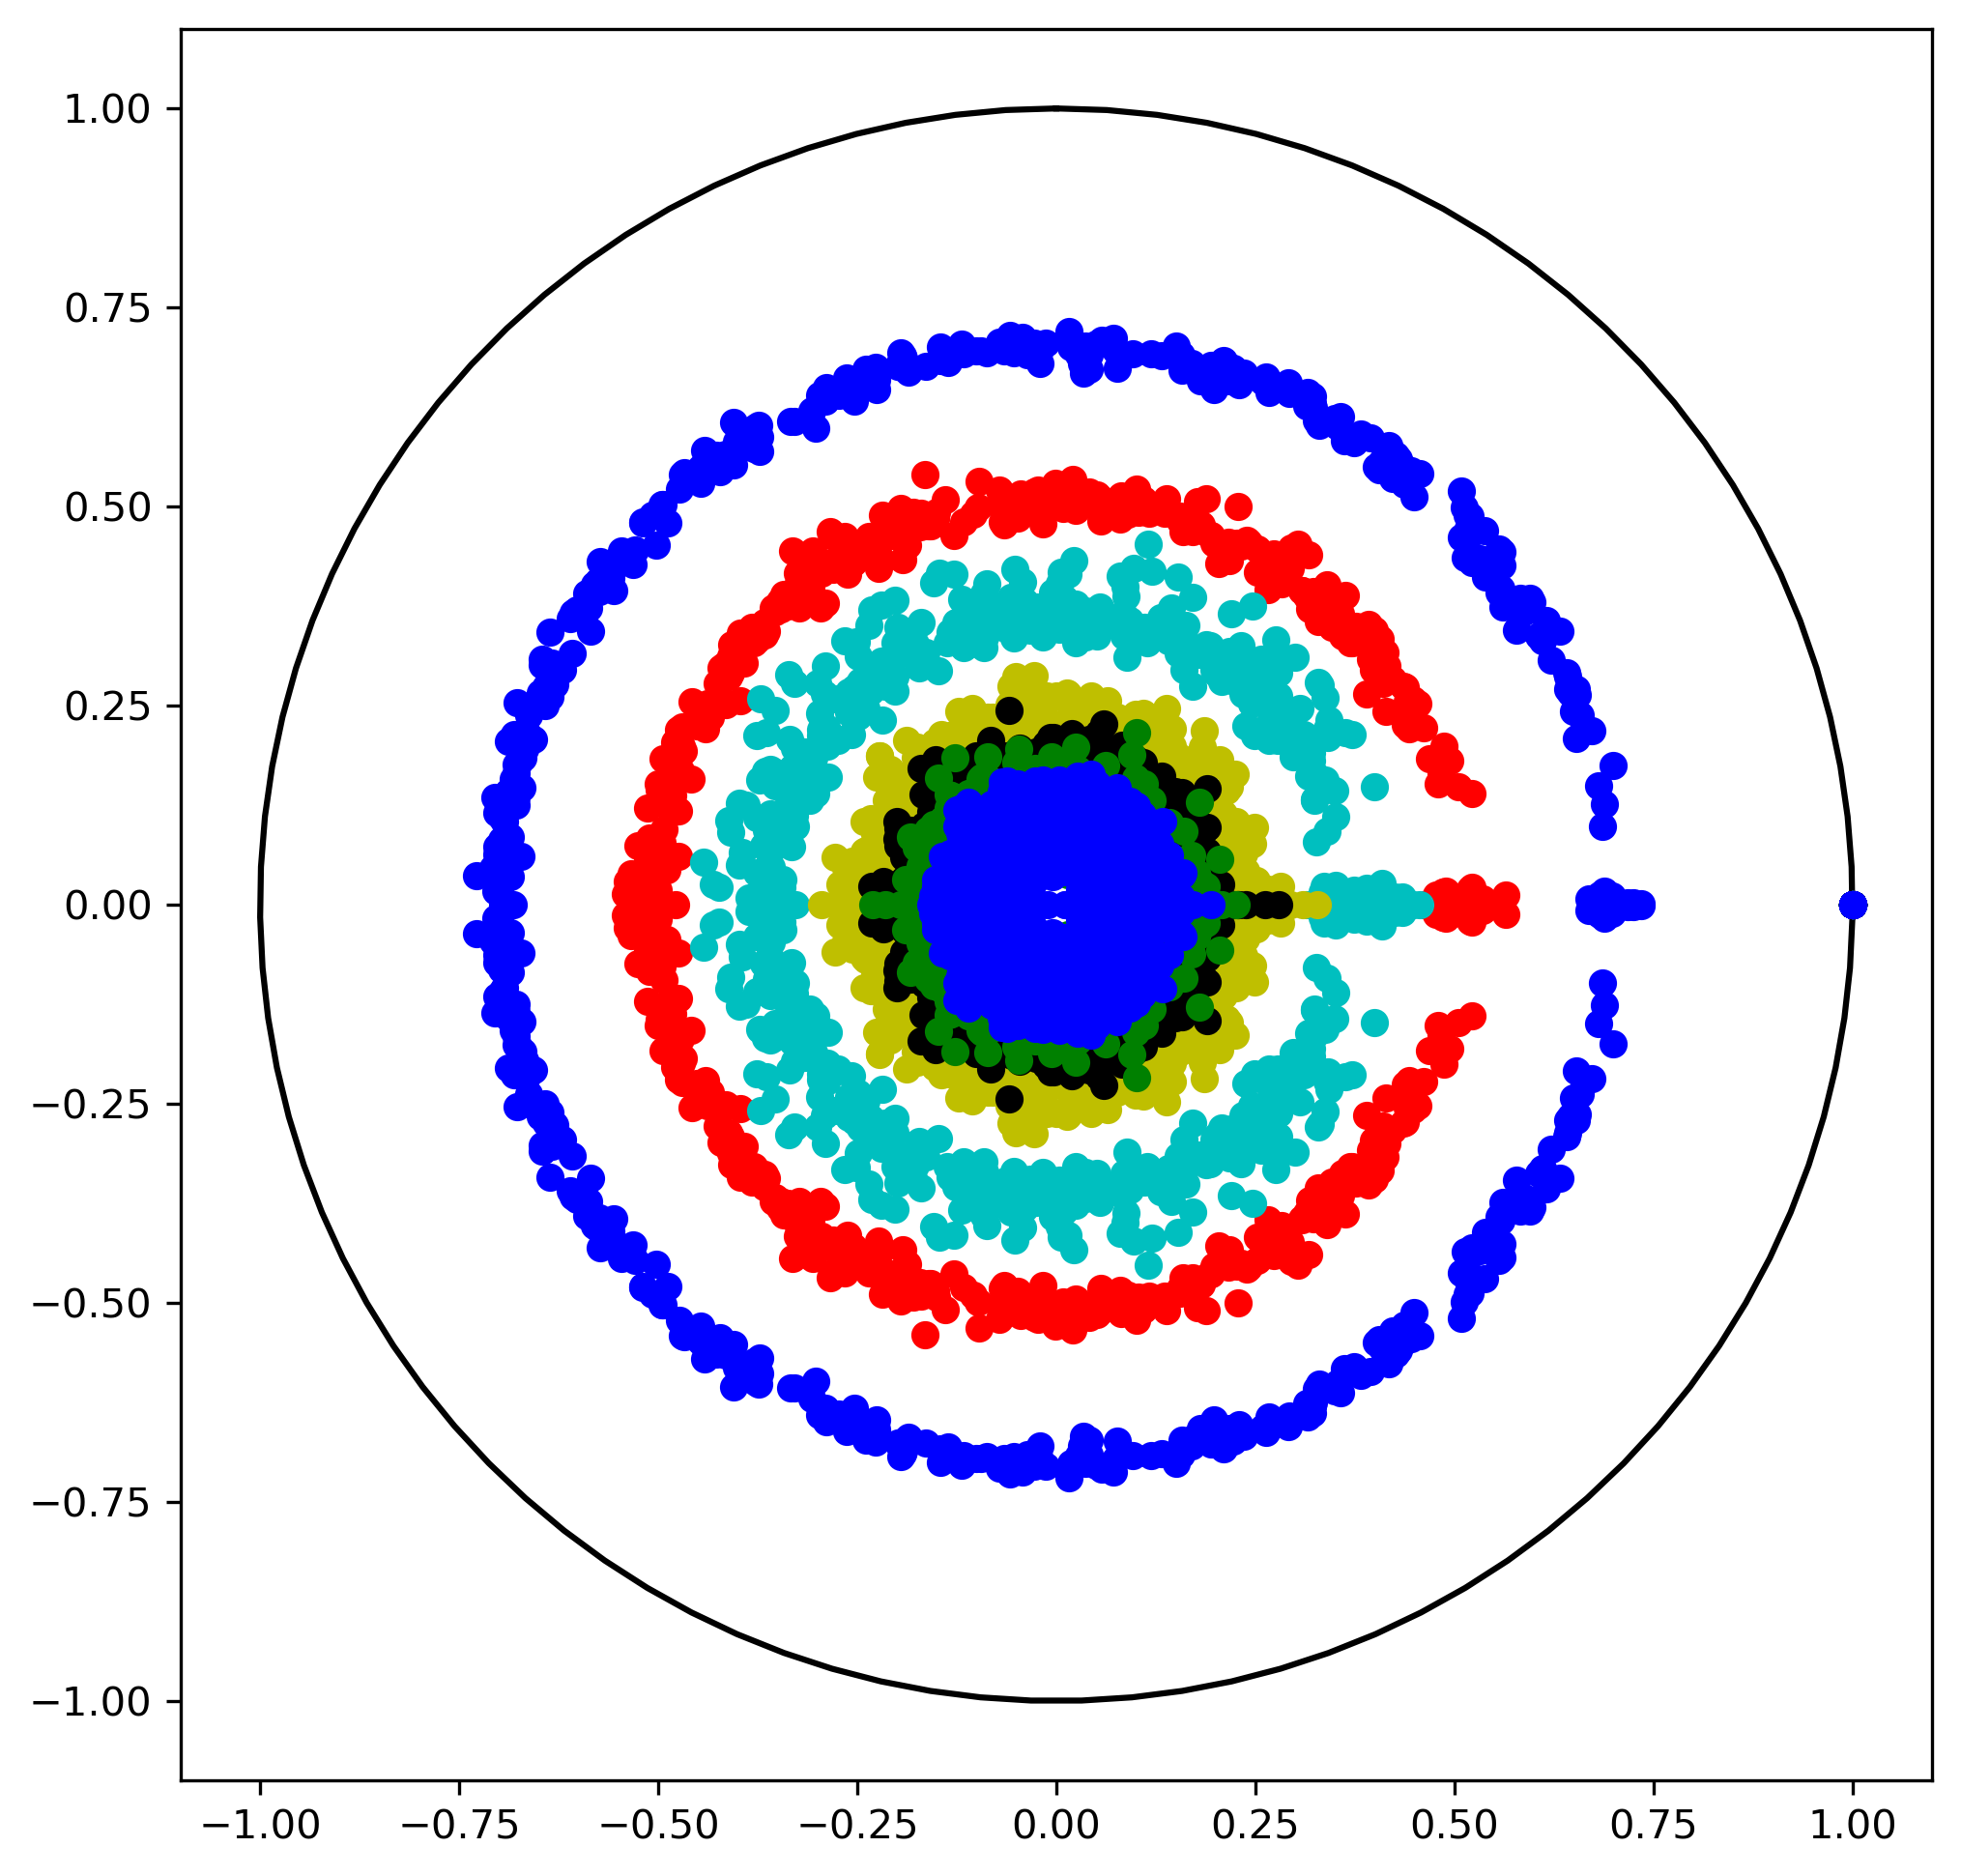

In [19]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

fig = plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

for spectrum in spectrum_list1:
    plt.plot(spectrum[:,0], spectrum[:,1], "bo")
    
for spectrum in spectrum_list2:
    plt.plot(spectrum[:,0], spectrum[:,1], "ro")
    
for spectrum in spectrum_list3:
    plt.plot(spectrum[:,0], spectrum[:,1], "co")

for spectrum in spectrum_list4:
    plt.plot(spectrum[:,0], spectrum[:,1], "yo")
    
for spectrum in spectrum_list5:
    plt.plot(spectrum[:,0], spectrum[:,1], "ko")
    
for spectrum in spectrum_list6:
    plt.plot(spectrum[:,0], spectrum[:,1], "go")
    
for spectrum in spectrum_list7:
    plt.plot(spectrum[:,0], spectrum[:,1], "bo")


plt.show()

In [21]:
R_p1, R_m1, R_pStd1, R_mStd1 = find_outer_inner_R([spectrum_list1[i][:-1] for i in range(10)])
R_p2, R_m2, R_pStd2, R_mStd2 = find_outer_inner_R([spectrum_list2[i][:-1] for i in range(10)])
R_p3, R_m3, R_pStd3, R_mStd3 = find_outer_inner_R([spectrum_list3[i][:-1] for i in range(10)])
R_p4, R_m4, R_pStd4, R_mStd4 = find_outer_inner_R([spectrum_list4[i][:-1] for i in range(10)])
R_p5, R_m5, R_pStd5, R_mStd5 = find_outer_inner_R([spectrum_list5[i][:-1] for i in range(10)])
R_p6, R_m6, R_pStd6, R_mStd6 = find_outer_inner_R([spectrum_list6[i][:-1] for i in range(10)])
R_p7, R_m7, R_pStd7, R_mStd7 = find_outer_inner_R([spectrum_list7[i][:-1] for i in range(10)])

In [24]:
x = [8, 16, 24, 32, 40, 48, 56]
R_plus = np.array([R_p1, R_p2, R_p3, R_p4, R_p5, R_p6, R_p7])
R_minus = np.array([R_m1, R_m2, R_m3, R_m4, R_m5, R_m6, R_m7])
R_plus_std = np.array([R_pStd1, R_pStd2, R_pStd3, R_pStd4, R_pStd5, R_pStd6, R_pStd7])
R_minus_std = np.array([R_mStd1, R_mStd2, R_mStd3, R_mStd4, R_mStd5, R_mStd6, R_mStd7])

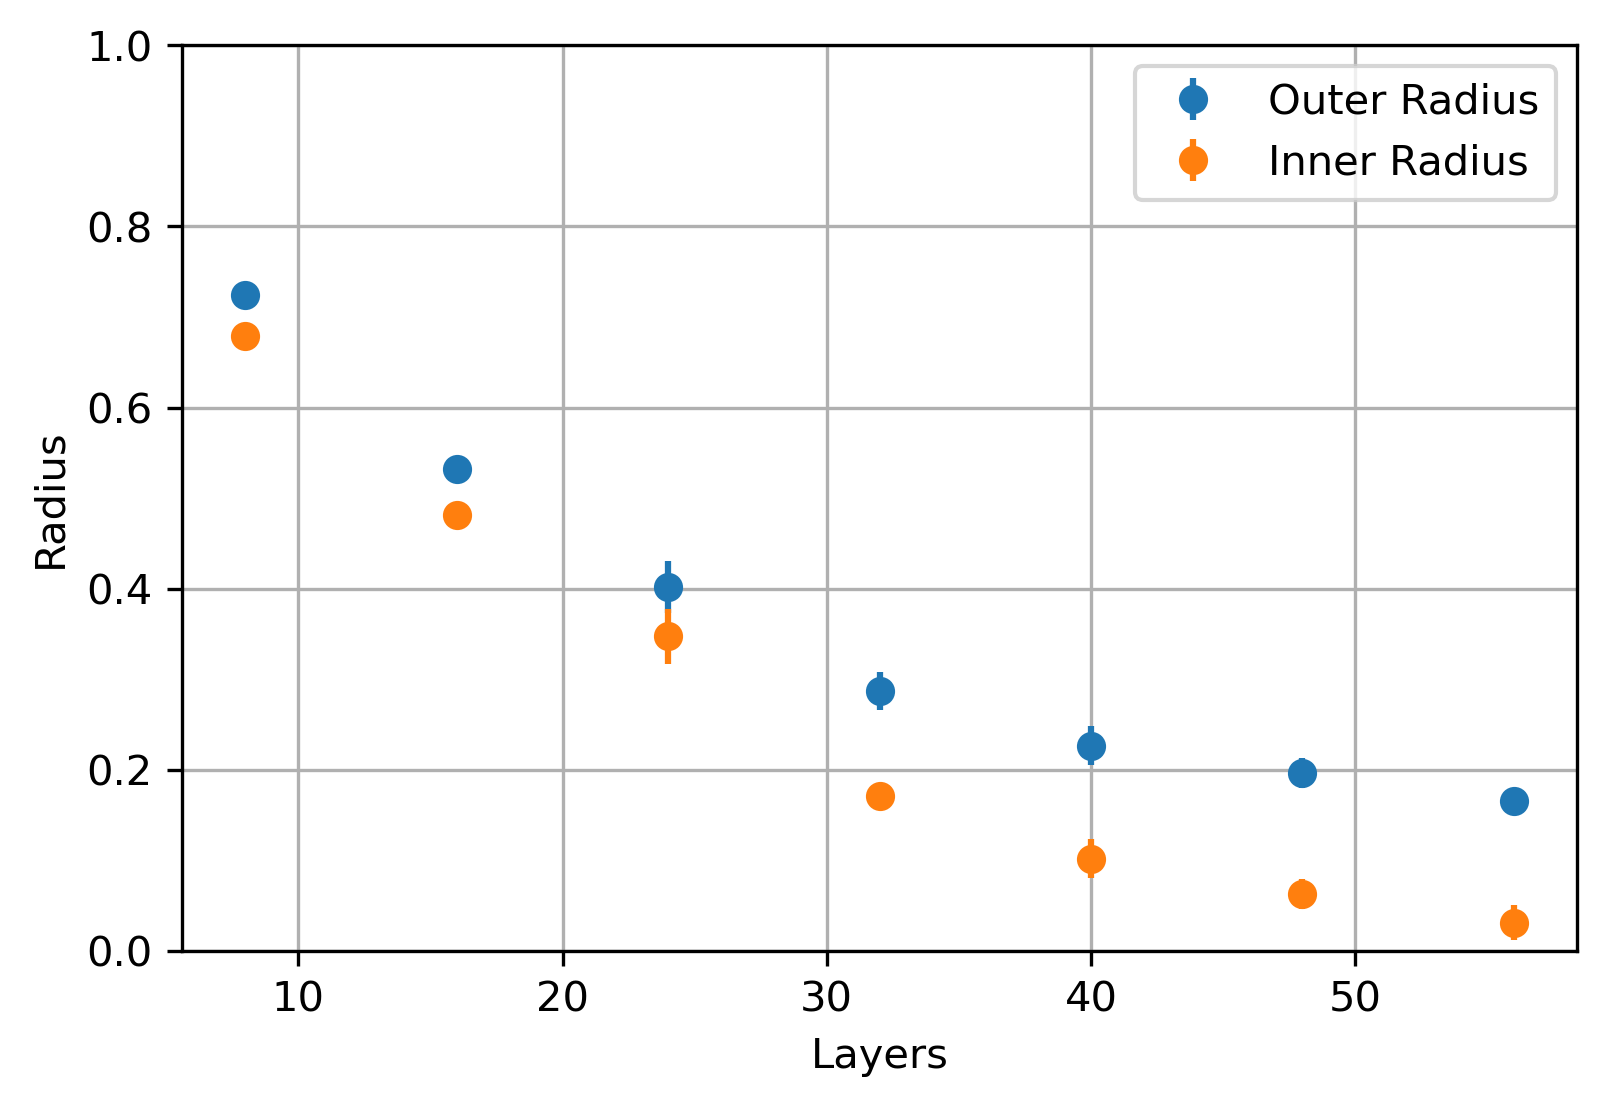

In [28]:
fig = plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')

plt.errorbar(x, R_plus, yerr=R_plus_std, fmt="o")
plt.errorbar(x, R_minus, yerr=R_minus_std, fmt="o")
#plt.plot(x, R_plus-R_minus, "o")
plt.ylim([0,1])
plt.grid()
plt.xlabel("Layers")
plt.ylabel("Radius")
plt.legend(["Outer Radius", "Inner Radius", "Differance"])
plt.show()

In [31]:
n = 3
d = 2**n

np.random.seed(42)
random.seed(42)
kraus_target_list1 = []

for i in range(10):
    U = Operator(pqc_basic(n, 8).reverse_bits()).data
    kraus_target = DilutedKrausMap(U=U, c=0.7, d=d, rank=4)
    kraus_target_list1.append(kraus_target)

spectrum_target_list1 = [channel_spectrum(channel) for channel in kraus_target_list1]


np.random.seed(42)
random.seed(42)
kraus_target_list2 = []

for i in range(10):
    U = Operator(pqc_basic(n, 16).reverse_bits()).data
    kraus_target = DilutedKrausMap(U=U, c=0.5, d=d, rank=10)
    kraus_target_list2.append(kraus_target)

spectrum_target_list2 = [channel_spectrum(channel) for channel in kraus_target_list2]

np.random.seed(42)
random.seed(42)
kraus_target_list3 = []

for i in range(10):
    U = Operator(pqc_basic(n, 24).reverse_bits()).data
    kraus_target = DilutedKrausMap(U=U, c=0.35, d=d, rank=16)
    kraus_target_list3.append(kraus_target)

spectrum_target_list3 = [channel_spectrum(channel) for channel in kraus_target_list3]

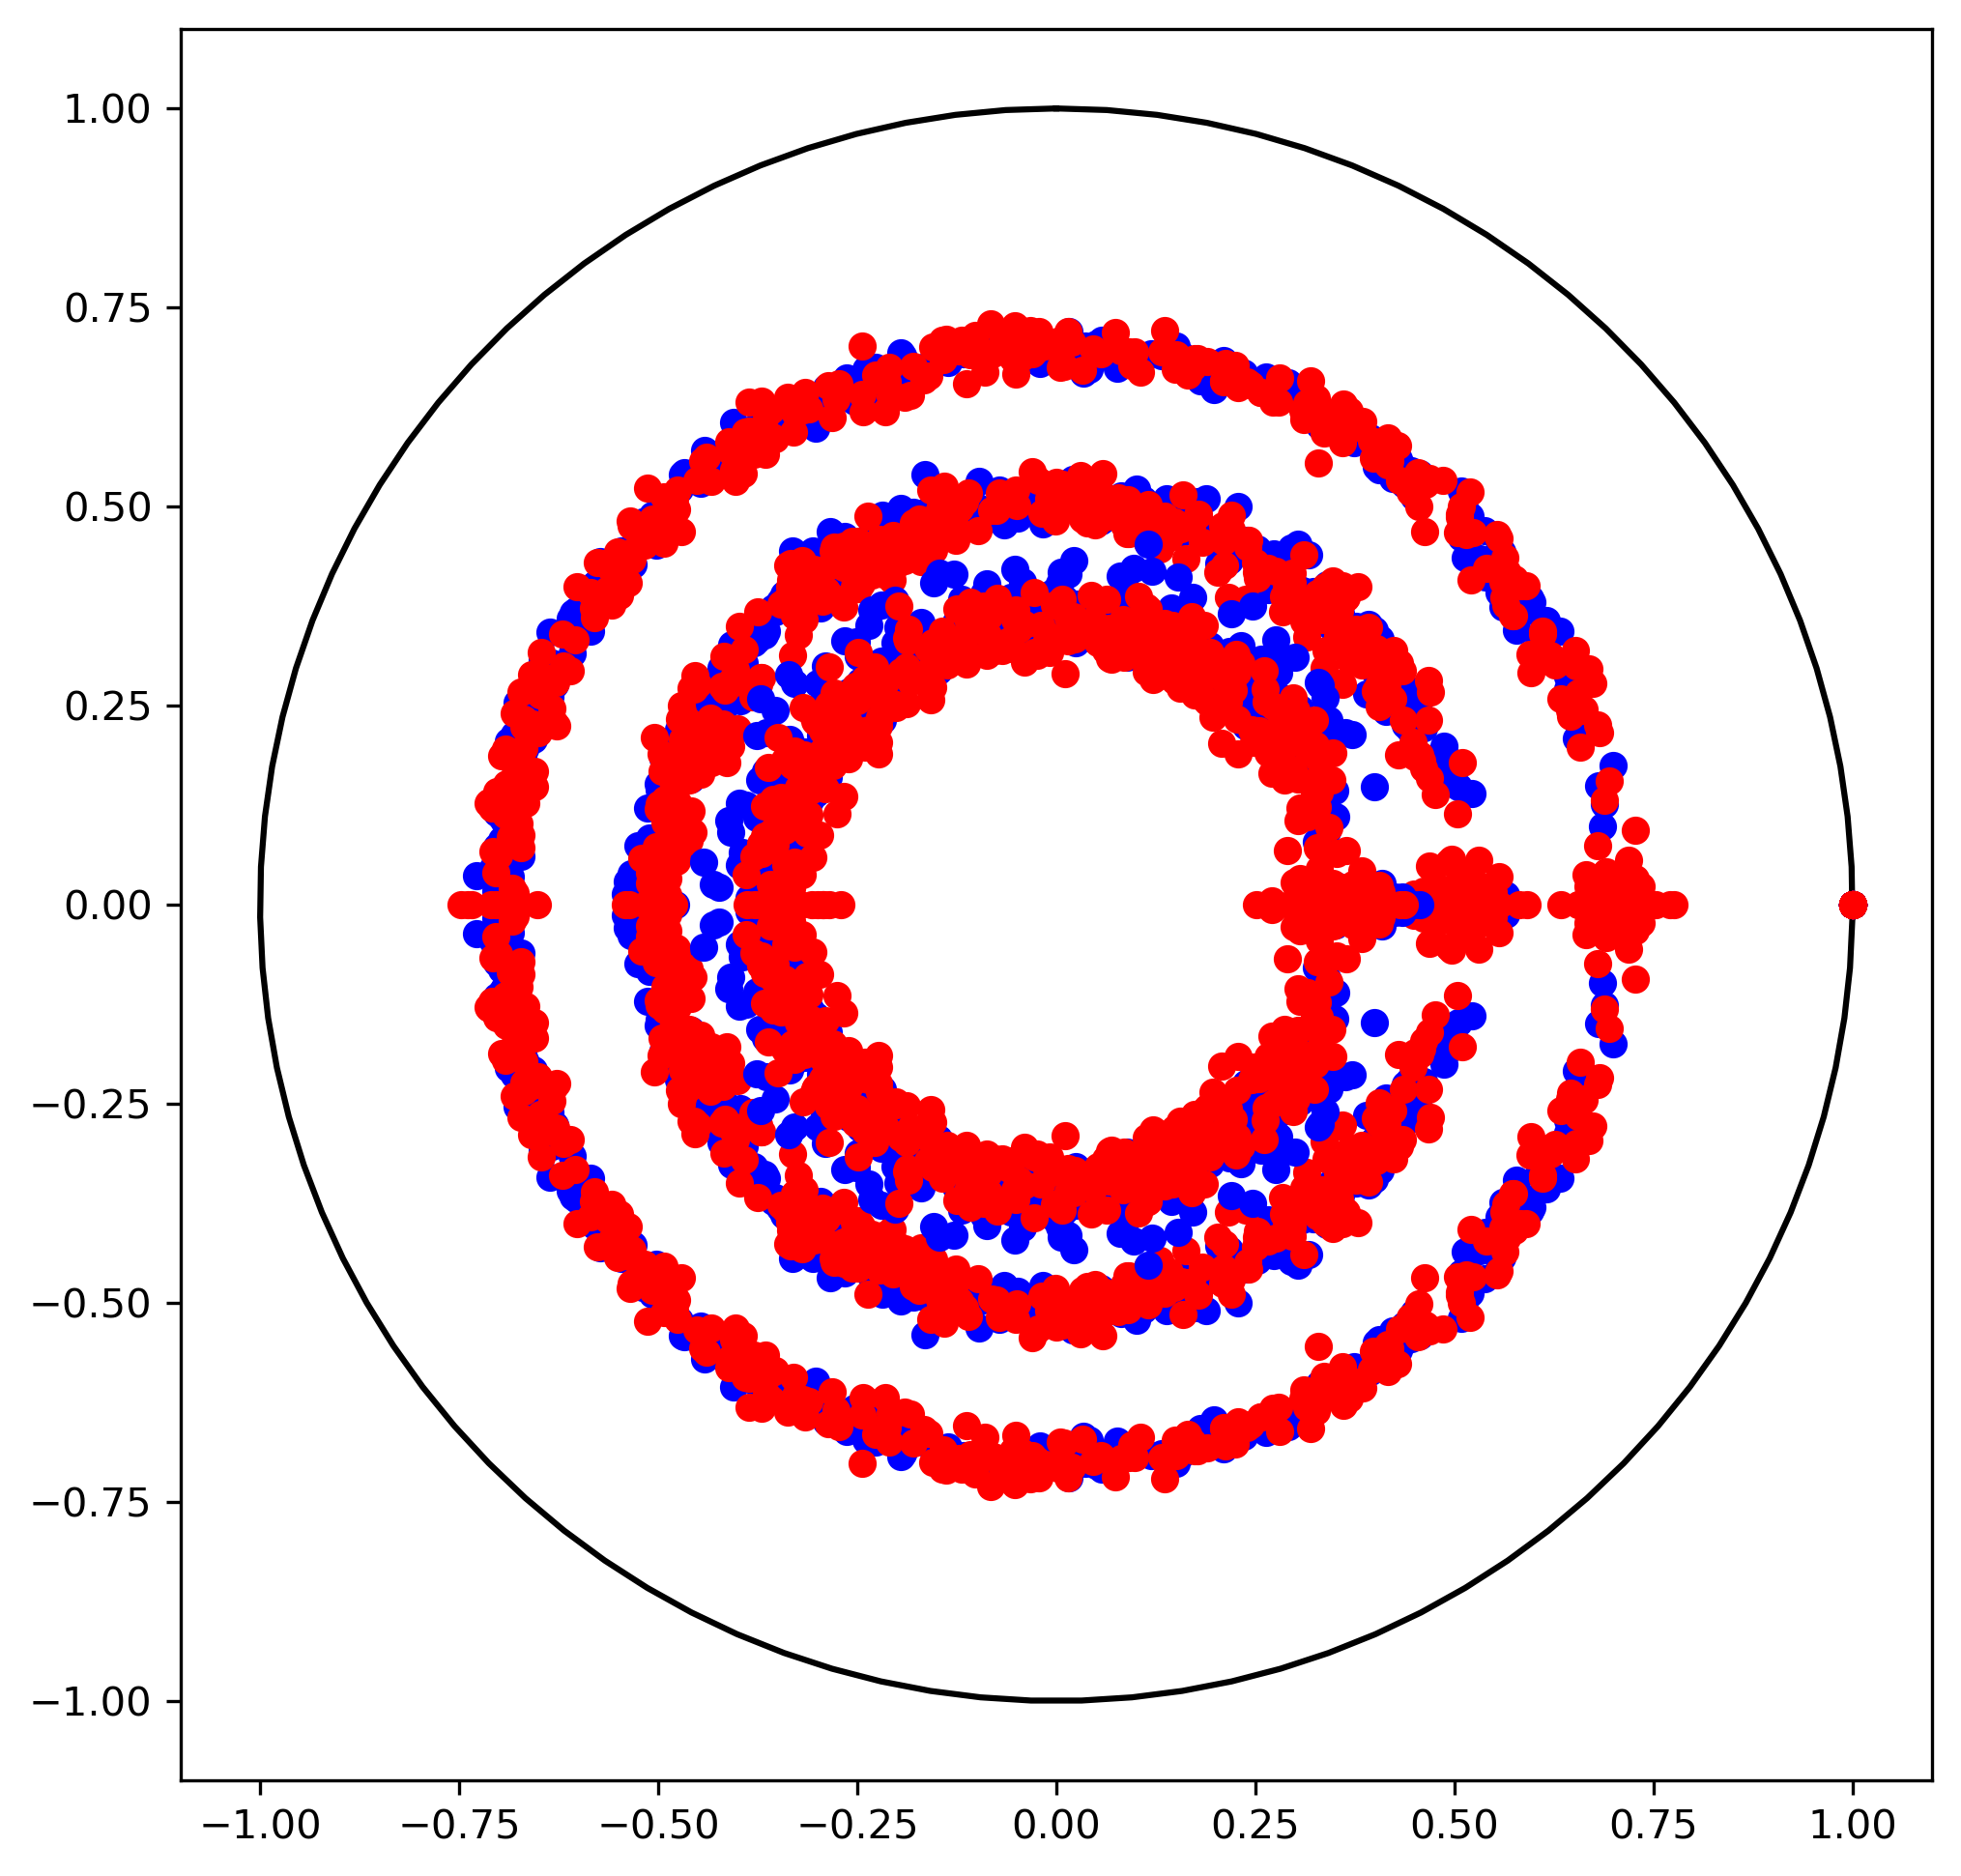

In [32]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

fig = plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

for spectrum in spectrum_list1:
    plt.plot(spectrum[:,0], spectrum[:,1], "bo")
    
for spectrum in spectrum_target_list1:
    plt.plot(spectrum[:,0], spectrum[:,1], "ro")
    
for spectrum in spectrum_list2:
    plt.plot(spectrum[:,0], spectrum[:,1], "bo")
    
for spectrum in spectrum_target_list2:
    plt.plot(spectrum[:,0], spectrum[:,1], "ro")
    
for spectrum in spectrum_list3:
    plt.plot(spectrum[:,0], spectrum[:,1], "bo")
    
for spectrum in spectrum_target_list3:
    plt.plot(spectrum[:,0], spectrum[:,1], "ro")


plt.show()

### Angular Distribution

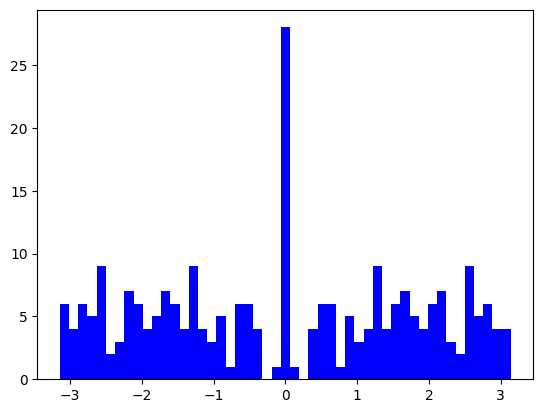

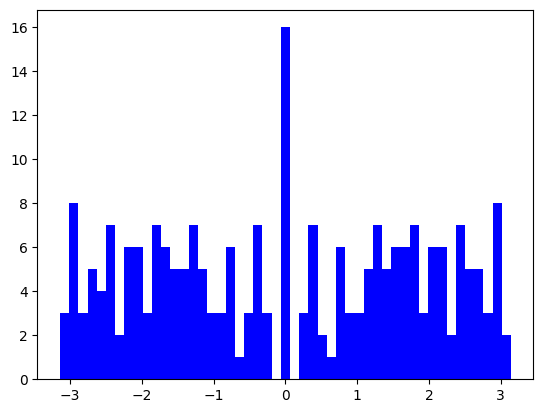

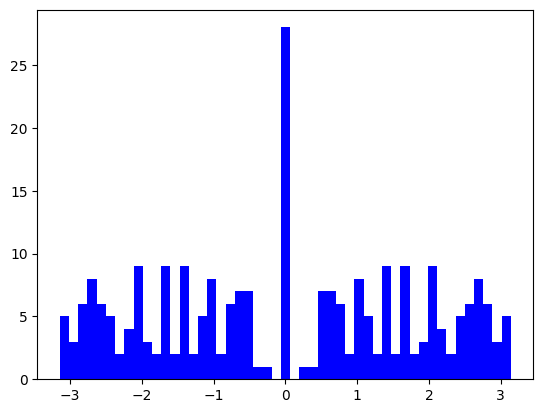

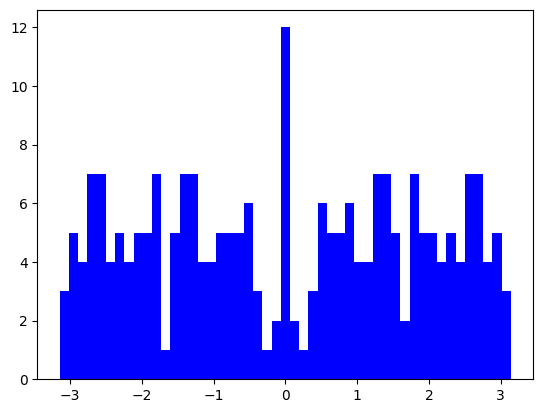

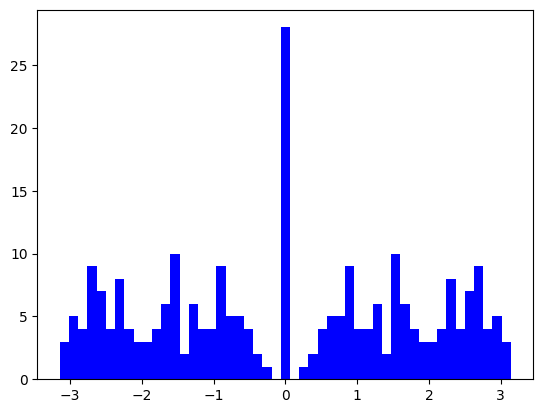

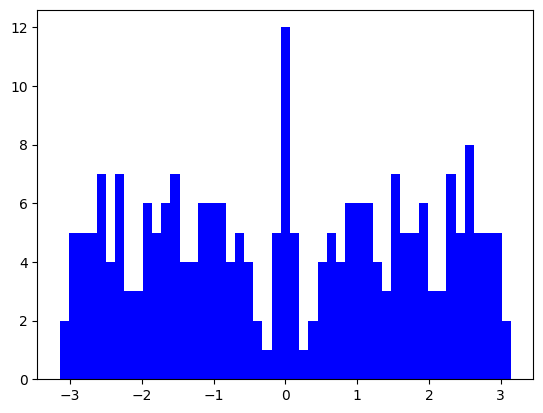

In [33]:
#fig = plt.figure(figsize=(3,3), dpi = 300, facecolor='w', edgecolor='k')
#ax = fig.add_subplot(111)
angular_histogram(spectrum_list1, bins=np.linspace(-np.pi, np.pi))
plt.show()
angular_histogram(spectrum_target_list1, bins=np.linspace(-np.pi, np.pi))
plt.show()

angular_histogram(spectrum_list2, bins=np.linspace(-np.pi, np.pi))
plt.show()
angular_histogram(spectrum_target_list2, bins=np.linspace(-np.pi, np.pi))
plt.show()

angular_histogram(spectrum_list3, bins=np.linspace(-np.pi, np.pi))
plt.show()
angular_histogram(spectrum_target_list3, bins=np.linspace(-np.pi, np.pi))
plt.show()

## Purity of Steady State

In [43]:
belem_purity_list1 = [state_purity(channel_steady_state(channel)) for channel in channel_list1]
kraus_purity_list1 = [state_purity(channel_steady_state(channel)) for channel in kraus_target_list1]

belem_purity_list2 = [state_purity(channel_steady_state(channel)) for channel in channel_list2]
kraus_purity_list2 = [state_purity(channel_steady_state(channel)) for channel in kraus_target_list2]

belem_purity_list2 = [state_purity(channel_steady_state(channel)) for channel in channel_list2]
kraus_purity_list2 = [state_purity(channel_steady_state(channel)) for channel in kraus_target_list2]

belem_purity_list7 = [state_purity(channel_steady_state(channel)) for channel in channel_list7]
#kraus_purity_list7 = [state_purity(channel_steady_state(channel)) for channel in kraus_target_list7]

In [37]:
print(np.abs(np.array(belem_purity_list1)))
print(np.abs(np.array(kraus_purity_list1)))
print("-----")
print(np.abs(np.array(belem_purity_list2)))
print(np.abs(np.array(kraus_purity_list2)))

[0.1259 0.1262 0.1269 0.1255]
[0.1307 0.1314 0.1296 0.1291]
-----
[0.1259 0.126  0.1262 0.1261]
[0.1288 0.1288 0.1281 0.1284]


### Effective Rank

In [50]:
belem_effRank_list1 = [effective_rank(channel) for channel in channel_list1]
kraus_effRank_list1 = [effective_rank(channel) for channel in kraus_target_list1]

belem_effRank_list2 = [effective_rank(channel) for channel in channel_list2]
kraus_effRank_list2 = [effective_rank(channel) for channel in kraus_target_list2]

belem_effRank_list3 = [effective_rank(channel) for channel in channel_list3]
kraus_effRank_list3 = [effective_rank(channel) for channel in kraus_target_list3]

belem_effRank_list7 = [effective_rank(channel) for channel in channel_list7]
#kraus_effRank_list3 = [effective_rank(channel) for channel in kraus_target_list3]

In [51]:
print(np.abs(np.array(belem_effRank_list1)))
print(np.abs(np.array(kraus_effRank_list1)))
print("-----")

print(np.abs(np.array(belem_effRank_list2)))
print(np.abs(np.array(kraus_effRank_list2)))
print("-----")

print(np.abs(np.array(belem_effRank_list3)))
print(np.abs(np.array(kraus_effRank_list3)))
print("-----")
print(np.abs(np.array(belem_effRank_list7)))
#print(np.abs(np.array(kraus_effRank_list3)))
print("-----")


[2.063  1.9669 1.9799 2.0274]
[1.9189 1.9255 1.9384 1.9133]
-----
[3.5756 3.6656 3.9043 3.5228]
[3.4888 3.4872 3.4589 3.4765]
-----
[6.2866 6.2715 5.8807 6.7   ]
[6.1928 6.1562 6.2503 6.1062]
-----
[22.7841 24.5647 25.5723 25.3715]
-----


## Concatentation

In [4]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

model1 = fit_model("lima_concatenate0",  16)
model2 = fit_model("lima_concatenate1",  16)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.0015061412306877908


  0%|          | 0/4000 [00:00<?, ?it/s]

0.0038851482324423654 None


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.001455118169158782


  0%|          | 0/4000 [00:00<?, ?it/s]

0.005974170488778111 None


In [ ]:
model12 = fit_model("lima_concatenate_full0",  16)

In [1]:
channel1 = model1.channel
channel2 = model2.channel
channel_full = model12.channel
channel_concat = channel_to_choi_map([channel1, channel2])

spectrum_concat = channel_spectrum(channel_concat, use_coords=True)
spectrum_full = channel_spectrum(channel_full, use_coords=True)

NameError: name 'model1' is not defined

In [2]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

fig = plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

plt.plot(spectrum_concat[:,0], spectrum_concat[:,1], "bo")
plt.plot(spectrum_full[:,0], spectrum_full[:,1], "ro")

plt.show()

NameError: name 'np' is not defined

In [63]:
print(channel_fidelity(channel_full, channel_full))

tf.Tensor(1.0000001278469197, shape=(), dtype=float64)


In [5]:
model = fit_model(f"belem_4qubits_8layers0",  64)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

0.04797593841629904


  0%|          | 0/4000 [00:00<?, ?it/s]

0.008201610586743261 None


In [6]:
channel = model.channel

In [7]:
spectrum = channel_spectrum(channel)

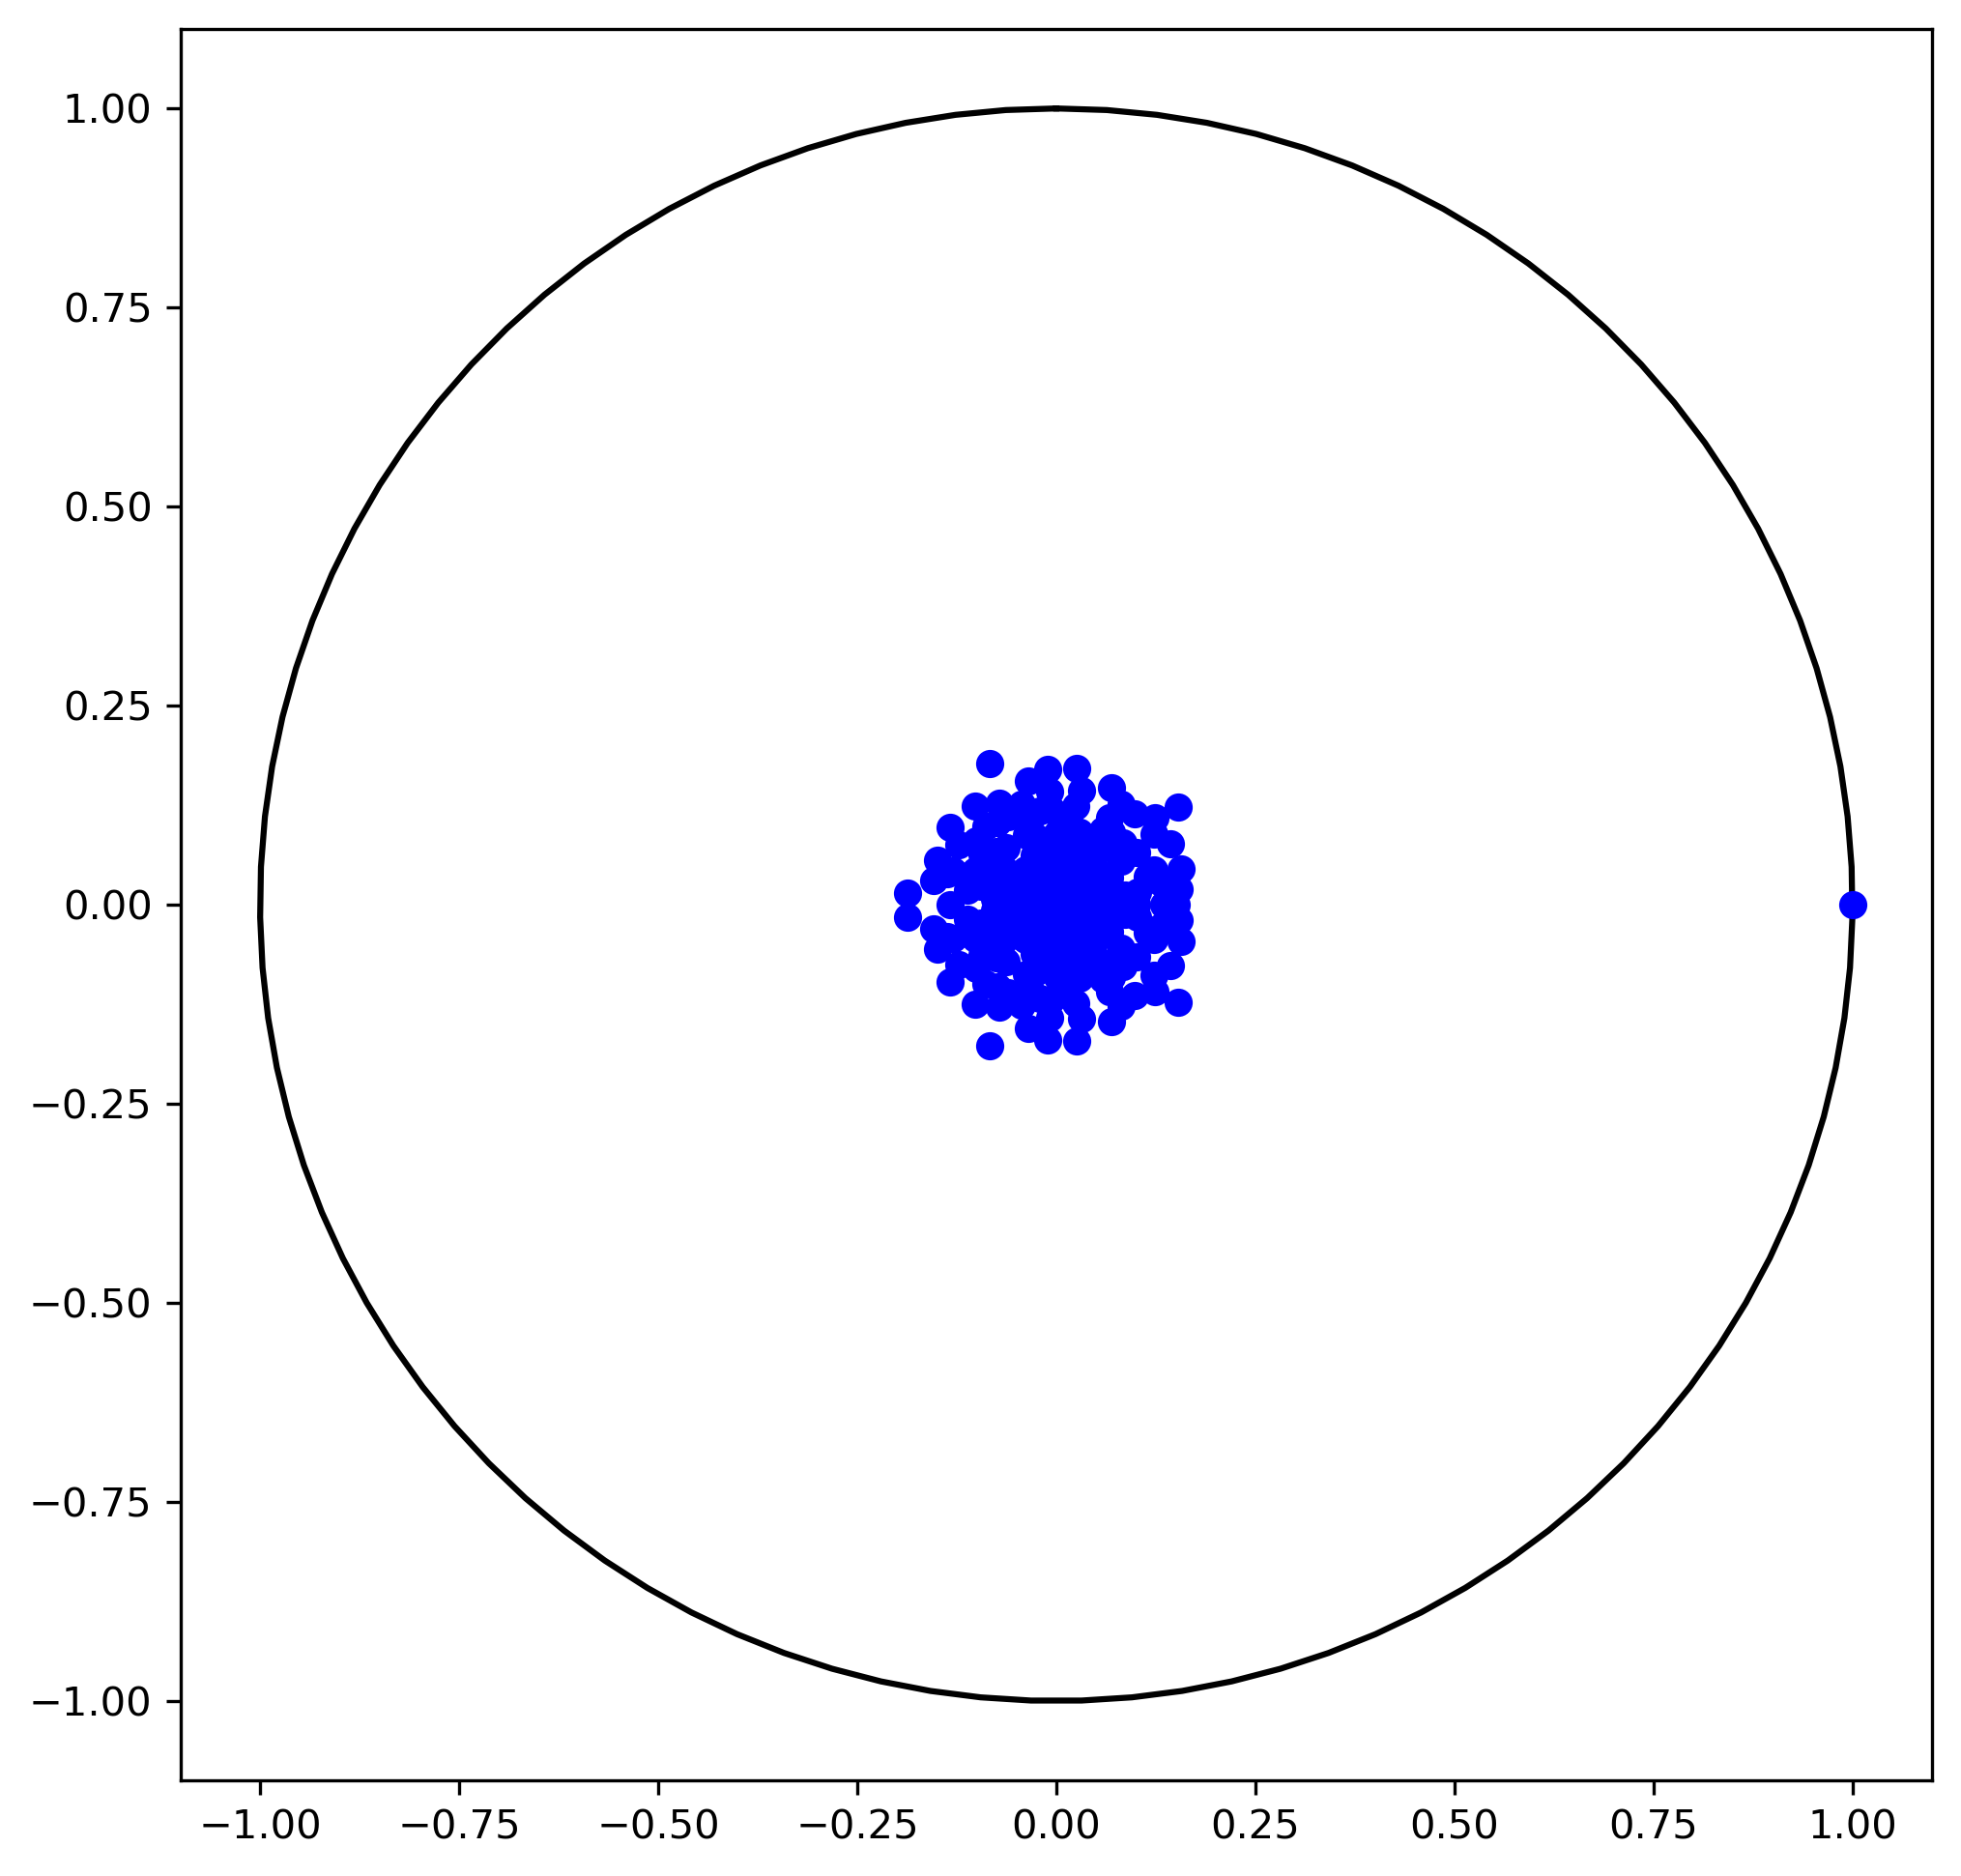

In [10]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

fig = plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")
plt.plot(spectrum[:,0], spectrum[:,1], "bo")

## Four Qubits

### Four Layers

In [56]:
inputs_map, targets_map, inputs_spam, targets_spam =  pickle.load(open(f"../../data/{'belem_4qubits_4layers0'}", "rb"))
    
d = targets_map.shape[1]
n = int(np.log2(d))

np.random.seed(43)
random.seed(43)
tf.random.set_seed(43)

spam = SPAM(init = InitialState(d, c=0.9),
            povm = POVM(d, c=0.9),
            optimizer = tf.optimizers.Adam(learning_rate=0.01),
            )

#spam.pretrain(num_iter = 1000, verbose=True)

spam.train(inputs = inputs_spam,
           targets = targets_spam,
           num_iter = 1000,
           verbose=True,
          )

  0%|          | 0/1000 [00:00<?, ?it/s]

0 0.03162285479954864
1 0.031523156002715054
2 0.03141934981490565
3 0.03131435646037478
4 0.031209379235958696
5 0.031105051758086515
6 0.03100176255320244
7 0.030899771264781918
8 0.030799214188599475
9 0.030700205831388327
10 0.030602740197047
11 0.030506849063631384
12 0.03041249560665171
13 0.03031964110348943
14 0.030228163310860815
15 0.030137974137399614
16 0.03004894022721969
17 0.029960892995213324
18 0.029873672582482694
19 0.029787025202112467
20 0.02970081426424517
21 0.029614760365264448
22 0.029528684223660662
23 0.02944244643795373
24 0.029355776307018324
25 0.029268513250116077
26 0.02918042012421064
27 0.02909139584489618
28 0.029001330839243753
29 0.028910094414409004
30 0.0288175267437753
31 0.028723577760392825
32 0.028628133773682486
33 0.028531137088003793
34 0.02843248655800123
35 0.028332055860501706
36 0.02822984528789969
37 0.028125857621091786
38 0.028020019621562923
39 0.027912329022335303
40 0.027802767104866156
41 0.02769126499655275
42 0.0275778129110233

334 0.0028575942990803423
335 0.0028524082494856156
336 0.002847425120239608
337 0.0028426112984531
338 0.0028379128175213633
339 0.00283325592443565
340 0.0028286770247276075
341 0.002824188495610259
342 0.0028198032750563315
343 0.0028155242675430583
344 0.002811345334123025
345 0.0028071685292028483
346 0.0028028719901855635
347 0.0027985450575568034
348 0.002794223881842011
349 0.002789917352449071
350 0.0027856507545017803
351 0.0027814515146181145
352 0.0027773167945671657
353 0.0027733136215370015
354 0.002769449759912548
355 0.0027657119054753884
356 0.0027619583011114454
357 0.002758248816145954
358 0.0027545796871826377
359 0.0027508135389288924
360 0.0027469197969791225
361 0.0027430484875726785
362 0.002739224512241088
363 0.0027354740796418065
364 0.002731772414910272
365 0.002728169497037678
366 0.0027246600486227402
367 0.002721295828244269
368 0.002718021143003801
369 0.002714480730903929
370 0.002711112473376725
371 0.0027075139249576386
372 0.002703922385444717
373 0.

656 0.002256040505550595
657 0.002255146447800984
658 0.002254204797012334
659 0.0022533366707063584
660 0.002252071280926903
661 0.0022509947379755193
662 0.0022501670720368487
663 0.0022490896749305963
664 0.0022483678297093982
665 0.0022464874717650998
666 0.002245126494852092
667 0.0022442745896602096
668 0.0022424994469050666
669 0.0022413090394696566
670 0.0022406347363614423
671 0.002240311285842725
672 0.0022402240880236464
673 0.002240248334603235
674 0.0022402362965257476
675 0.002240088163049559
676 0.0022396212814284047
677 0.0022387513878583455
678 0.0022377577586044813
679 0.0022367745734634672
680 0.0022358674267774032
681 0.0022350478637550193
682 0.002234405397142066
683 0.002233998944044971
684 0.00223381787843081
685 0.0022338668667639164
686 0.00223407778403422
687 0.0022342443933511644
688 0.0022341547757907926
689 0.0022336392746603213
690 0.0022328876633013407
691 0.0022320597061727277
692 0.0022312443158866192
693 0.0022303956053502296
694 0.0022285624170091333


978 0.002082078586801891
979 0.002081654242170588
980 0.002081273694303447
981 0.0020810042362109384
982 0.00208063711923748
983 0.002080479743444907
984 0.002080471726417625
985 0.00208055580258051
986 0.0020808205017910316
987 0.002081187689961382
988 0.0020814030705975407
989 0.0020813553567721886
990 0.0020813549748254917
991 0.002081486986014121
992 0.0020817146952975658
993 0.002081949763341101
994 0.0020822141472010424
995 0.0020825158375706687
996 0.0020828452147855707
997 0.002083206637641711
998 0.002082537941786344
999 0.002081804510719232
0.002081804510719232


In [57]:
model1 = ModelQuantumMap(channel = KrausMap(d=d, 
                                           rank=256,
                                           spam = spam,
                                           ),
                               loss_function = ProbabilityMSE(),
                               optimizer = tf.optimizers.Adam(learning_rate=0.01),
                               logger = Logger(loss_function = ProbabilityMSE(), verbose=True),
                               )

model1.train(inputs = inputs_map,
            targets = targets_map,
            num_iter = 2000,
            N=500,
            )

  0%|          | 0/2000 [00:00<?, ?it/s]

0.12741418098319723 None
0.06274366403006333 None
0.03676032049430684 None
0.033278918809112545 None
0.032021945923468215 None
0.031280645710802885 None
0.030857013673771205 None
0.03051090172328931 None
0.030264760941137666 None
0.030115758226711753 None
0.02997483711173963 None
0.029849471136422823 None
0.029758018264655236 None
0.029675045846573937 None
0.029604645954055105 None
0.029554959796106704 None
0.029512129214884848 None
0.029483788431277837 None
0.029445466710879404 None
0.029424324365082206 None
0.02941936126466545 None


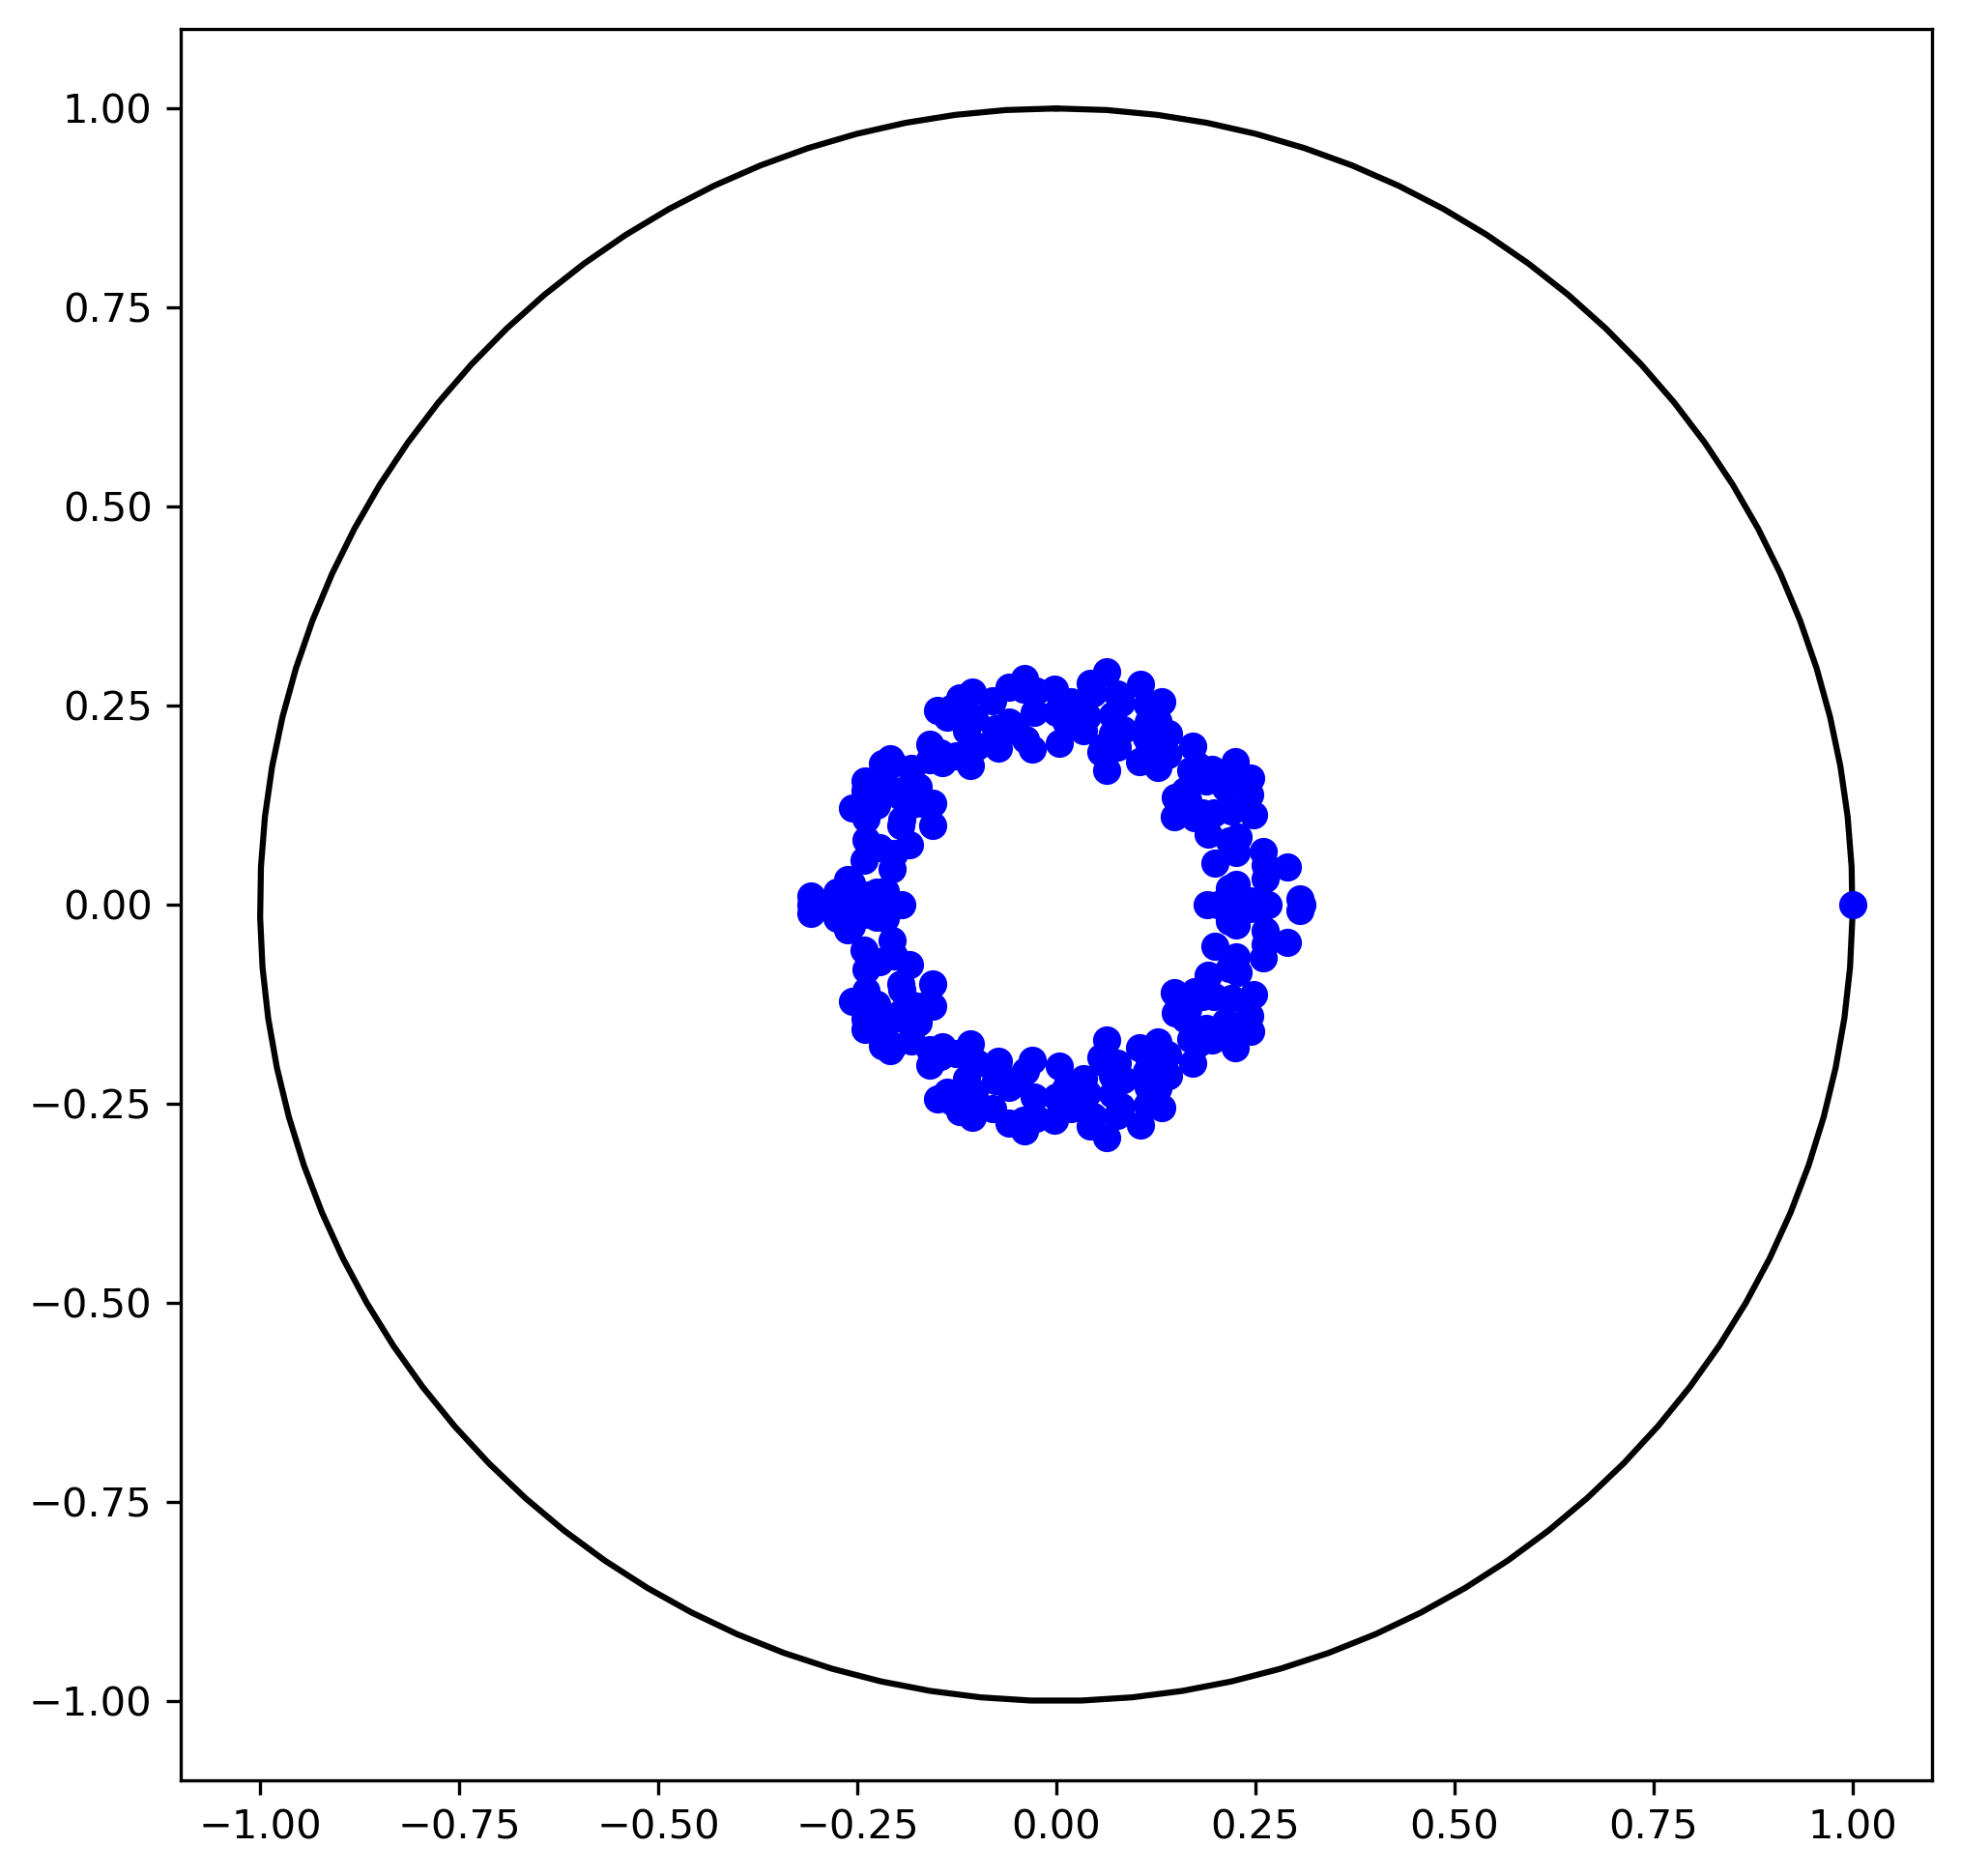

In [58]:
channel1 = model1.channel
spectrum1 = channel_spectrum(channel1, use_coords=True)

t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

fig = plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")
plt.plot(spectrum1[:,0], spectrum1[:,1], "bo")

### Five Layers

In [59]:
inputs_map, targets_map, inputs_spam, targets_spam =  pickle.load(open(f"../../data/{'belem_4qubits_5layers0'}", "rb"))
    
d = targets_map.shape[1]
n = int(np.log2(d))

np.random.seed(43)
random.seed(43)
tf.random.set_seed(43)

spam = SPAM(init = InitialState(d, c=0.9),
            povm = POVM(d, c=0.9),
            optimizer = tf.optimizers.Adam(learning_rate=0.01),
            )

#spam.pretrain(num_iter = 1000, verbose=True)

spam.train(inputs = inputs_spam,
           targets = targets_spam,
           num_iter = 1000,
           verbose=True,
          )

  0%|          | 0/1000 [00:00<?, ?it/s]

0 0.032594582322539804
1 0.03250071561420802
2 0.03240241797347664
3 0.032302787044455716
4 0.03220305009252283
5 0.03210385546306058
6 0.032005540410691105
7 0.03190830850071366
8 0.031812223091662546
9 0.03171723628679129
10 0.03162323492256366
11 0.031530038588870685
12 0.03143740755476494
13 0.03134505820706397
14 0.03125266271282559
15 0.0311599535284312
16 0.03106663619485211
17 0.03097250840285778
18 0.030877321563727033
19 0.030780951088502383
20 0.030683184802043323
21 0.03058393239742209
22 0.030483118505232297
23 0.030380558625425016
24 0.0302762536637199
25 0.030170084113723513
26 0.030062096235099516
27 0.029952163193692233
28 0.029840309599576592
29 0.029726466252370253
30 0.029610462921310494
31 0.02949243658787592
32 0.029372287608970156
33 0.029250024768643856
34 0.029125684386871704
35 0.028999328382879785
36 0.0288707216951492
37 0.028740063266754292
38 0.02860718757036
39 0.02847224350440669
40 0.028334992531514336
41 0.028195543863901464
42 0.02805381786324798
43 0

334 0.002764835807497328
335 0.002760021137854846
336 0.0027555821756966477
337 0.0027510495277906573
338 0.0027468359341362996
339 0.0027428024719051815
340 0.002738853282266594
341 0.002734937369640099
342 0.0027309800447148274
343 0.00272712573291334
344 0.002722781363232421
345 0.002717470713346778
346 0.0027126504557310306
347 0.002708426525559174
348 0.0027046963810402505
349 0.0027012040797932835
350 0.0026978298235257286
351 0.0026944115499029997
352 0.0026908981048695134
353 0.002687330085978109
354 0.0026836820540176894
355 0.002679681182390141
356 0.0026756764725739935
357 0.0026718561229480595
358 0.0026682376876047595
359 0.0026648033472573083
360 0.0026608977834522286
361 0.0026571978374884454
362 0.0026537609830092996
363 0.0026505654949457633
364 0.00264752468440334
365 0.0026442146782967085
366 0.002640904113316223
367 0.0026376650642257055
368 0.0026344380334592144
369 0.00263127826582709
370 0.0026282050293171474
371 0.0026252274267671706
372 0.0026223571688654564
37

656 0.00220064118011262
657 0.002200138088192046
658 0.002199698536454566
659 0.0021993151061910064
660 0.0021989710142020415
661 0.0021986698498375206
662 0.0021983102045296334
663 0.002197621409574223
664 0.0021953710472565166
665 0.002192439898388337
666 0.002190382795702792
667 0.0021888397110558407
668 0.002187757435819126
669 0.0021870951328548604
670 0.0021869079672587953
671 0.0021866516719289473
672 0.002186301527413906
673 0.00218586114715981
674 0.0021855143125495426
675 0.0021840193218018336
676 0.0021826815863799946
677 0.0021814648598465986
678 0.002180454716985191
679 0.0021794876722549075
680 0.0021787461422180243
681 0.0021782240209442115
682 0.0021778402525084134
683 0.0021775469851046956
684 0.002177275921123083
685 0.0021769869242466316
686 0.0021766097490659177
687 0.0021761153739836715
688 0.002175649003529657
689 0.002175183160072729
690 0.002174676728318157
691 0.002174121723231475
692 0.0021735567747573196
693 0.0021730004401904306
694 0.002172476431305767
695 

978 0.0020629594256904842
979 0.002062997754361658
980 0.002062789261100144
981 0.0020625680990359976
982 0.0020625340000798814
983 0.0020626550436743437
984 0.0020628344255549536
985 0.0020627723604889803
986 0.0020612698236409928
987 0.002061357296169097
988 0.002061495065891325
989 0.0020616757972505674
990 0.0020618844088781405
991 0.0020622399941049767
992 0.0020628455818929056
993 0.002063313172382096
994 0.0020636820817230474
995 0.002063804612983602
996 0.002064025677248869
997 0.002063163450228865
998 0.0020599871548632686
999 0.0020553531853194826
0.0020553531853194826


In [60]:
model2 = ModelQuantumMap(channel = KrausMap(d=d, 
                                           rank=256,
                                           spam = spam,
                                           ),
                               loss_function = ProbabilityMSE(),
                               optimizer = tf.optimizers.Adam(learning_rate=0.01),
                               logger = Logger(loss_function = ProbabilityMSE(), verbose=True),
                               )

model2.train(inputs = inputs_map,
            targets = targets_map,
            num_iter = 2000,
            N=500,
            )

  0%|          | 0/2000 [00:00<?, ?it/s]

0.10229090651737724 None
0.05177186770863829 None
0.033769716490526035 None
0.031076709379934148 None
0.030066721943060874 None
0.02946832888346532 None
0.029033838096947123 None
0.028748171973545282 None
0.028536596046925416 None
0.028361704999638793 None
0.02823706821679508 None
0.028122813698207197 None
0.028074063872845854 None
0.02794858284310162 None
0.027903370047919623 None
0.02784894191347959 None
0.02780587257245574 None
0.02776478187572325 None
0.027792263950678776 None
0.0277069897795698 None
0.02768823874610543 None


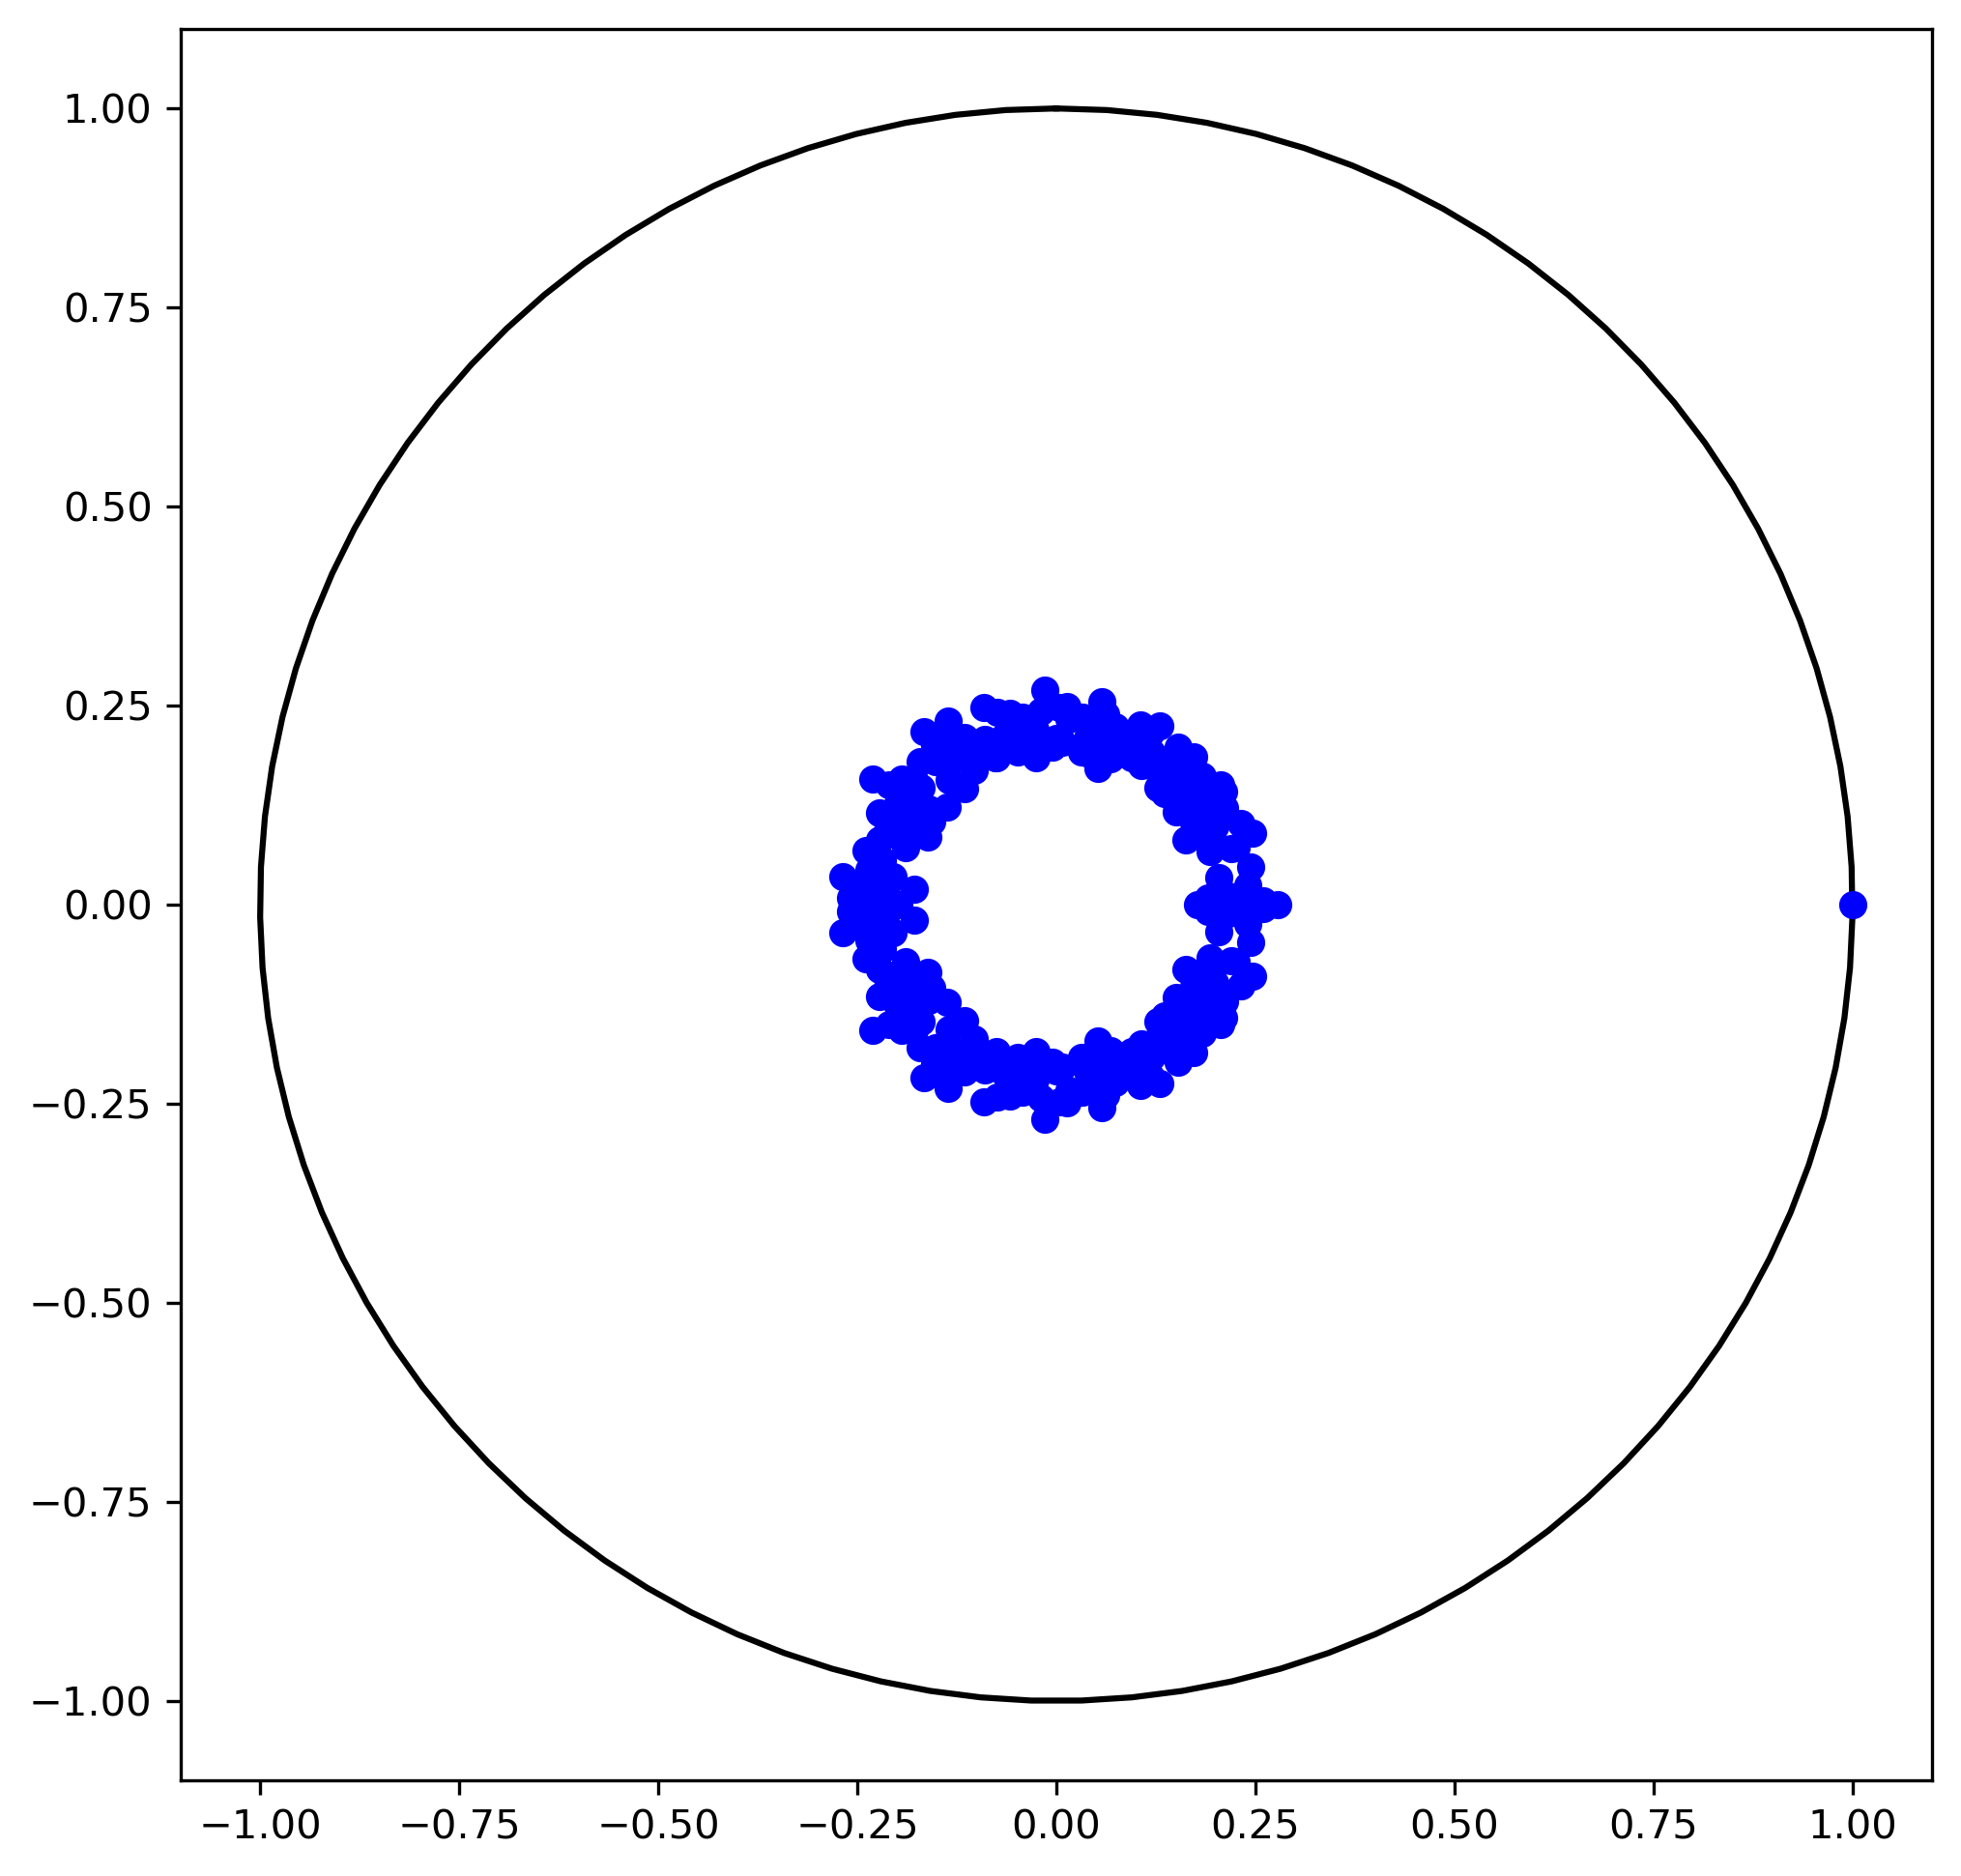

In [61]:
channel2 = model2.channel
spectrum2 = channel_spectrum(channel2, use_coords=True)

t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

fig = plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")
plt.plot(spectrum2[:,0], spectrum2[:,1], "bo")

### Six Layers

In [62]:
inputs_map, targets_map, inputs_spam, targets_spam =  pickle.load(open(f"../../data/{'belem_4qubits_6layers0'}", "rb"))
    
d = targets_map.shape[1]
n = int(np.log2(d))

np.random.seed(43)
random.seed(43)
tf.random.set_seed(43)

spam = SPAM(init = InitialState(d, c=0.9),
            povm = POVM(d, c=0.9),
            optimizer = tf.optimizers.Adam(learning_rate=0.01),
            )

#spam.pretrain(num_iter = 1000, verbose=True)

spam.train(inputs = inputs_spam,
           targets = targets_spam,
           num_iter = 1000,
           verbose=True,
          )

  0%|          | 0/1000 [00:00<?, ?it/s]

0 0.03213072910439911
1 0.03203465425028223
2 0.031934294452829845
3 0.03183266489200494
4 0.03173099587581062
5 0.03162994511684522
6 0.03152989997926627
7 0.03143105103586172
8 0.031333545824762526
9 0.031237442299089986
10 0.031142716868227366
11 0.031049286886498686
12 0.030957009855218473
13 0.030865729905971553
14 0.03077527894938297
15 0.030685437311774696
16 0.03059589516412422
17 0.030506443730214525
18 0.030416880099773405
19 0.03032689713134186
20 0.030236307717284094
21 0.030144778019318252
22 0.03005221441185631
23 0.029958489695563115
24 0.029863467395610997
25 0.029767015921770036
26 0.029669047127038675
27 0.02956945075480829
28 0.029468106962564314
29 0.029364990706482928
30 0.029259904372892134
31 0.029152854070439632
32 0.02904388121273692
33 0.028932992070336942
34 0.028820093650272938
35 0.028705153124012256
36 0.028588207782300593
37 0.02846913103536479
38 0.028347944403581193
39 0.02822467634387831
40 0.028099389451444013
41 0.027971781105943165
42 0.027842076663

334 0.0028327082091159144
335 0.0028278130285842866
336 0.002822658527577215
337 0.0028177718537040824
338 0.0028131426011894765
339 0.0028086615891711243
340 0.0028043538007923633
341 0.00280018844547879
342 0.0027961416068345178
343 0.002792199126493825
344 0.0027882931853506245
345 0.002784314258709179
346 0.0027802617896779134
347 0.002776177572057007
348 0.0027720912025743453
349 0.0027680003422632846
350 0.002763916261900847
351 0.002759860685921957
352 0.002755861693583537
353 0.002751985880811278
354 0.0027482763478178475
355 0.002744755659961532
356 0.002741409474287576
357 0.002738160946985964
358 0.0027348207796984696
359 0.0027313483829283437
360 0.002727820216443837
361 0.0027242401959020144
362 0.002720570157840577
363 0.0027168583534030203
364 0.0027131776931778734
365 0.002709572776620937
366 0.0027060941832878172
367 0.002702511347641076
368 0.0026991947342212483
369 0.0026961358408482934
370 0.002693101897119355
371 0.0026900968262537216
372 0.0026871238390610017
373 

656 0.0022375166432308685
657 0.002236127595487702
658 0.0022346240779482626
659 0.002233535195208838
660 0.0022327750245132805
661 0.002232265764319145
662 0.0022319353036415464
663 0.0022317473754012006
664 0.002231710726458074
665 0.0022318137249600937
666 0.0022319470004044284
667 0.0022316928281622948
668 0.0022313467891996496
669 0.002230757482197117
670 0.0022299871964745984
671 0.002229153187470472
672 0.002228345731935923
673 0.002227622642692311
674 0.002226983703123481
675 0.002225688237534875
676 0.0022241592114644487
677 0.0022230776755698695
678 0.0022222218280315256
679 0.002221353599826153
680 0.0022209338727152686
681 0.002220834146850792
682 0.0022207516205287733
683 0.0022206796798043328
684 0.002220178117073928
685 0.002219709837299686
686 0.002219277943219033
687 0.0022188546897313846
688 0.0022184430484139725
689 0.0022180101156568056
690 0.0022171145622265167
691 0.0022162320560051535
692 0.002214341955447132
693 0.002212968402795834
694 0.0022119278595432485
695

978 0.0020836518275223035
979 0.0020837965146347868
980 0.0020840044517628927
981 0.002082286991387315
982 0.002080961865692926
983 0.002080165948767587
984 0.002079805983841188
985 0.0020796855493668753
986 0.002079755326735161
987 0.0020799051485547834
988 0.002079921166368765
989 0.0020796511845393344
990 0.0020792527276462594
991 0.002078788191719186
992 0.002078327090390365
993 0.00207790003438606
994 0.0020769406038810938
995 0.002076299468453249
996 0.002075844664466643
997 0.0020754002010338747
998 0.0020748630365219384
999 0.002074198156240335
0.002074198156240335


In [63]:
model3 = ModelQuantumMap(channel = KrausMap(d=d, 
                                           rank=256,
                                           spam = spam,
                                           ),
                               loss_function = ProbabilityMSE(),
                               optimizer = tf.optimizers.Adam(learning_rate=0.01),
                               logger = Logger(loss_function = ProbabilityMSE(), verbose=True),
                               )

model3.train(inputs = inputs_map,
            targets = targets_map,
            num_iter = 2000,
            N=500,
            )

  0%|          | 0/2000 [00:00<?, ?it/s]

0.08206335922002132 None
0.04365117003735714 None
0.032068116249929265 None
0.02978186575018818 None
0.028815470821962102 None
0.028237114384343124 None
0.02785524674101021 None
0.02756225021117748 None
0.027348572223645787 None
0.02715343177582125 None
0.0270534069520356 None
0.026942710609103145 None
0.026857120165907047 None
0.02677280476573678 None
0.026704317372781762 None
0.026693004703771686 None
0.02664329894557872 None
0.026563066251182925 None
0.0265577446458185 None
0.02652777803806095 None
0.026511138240333208 None


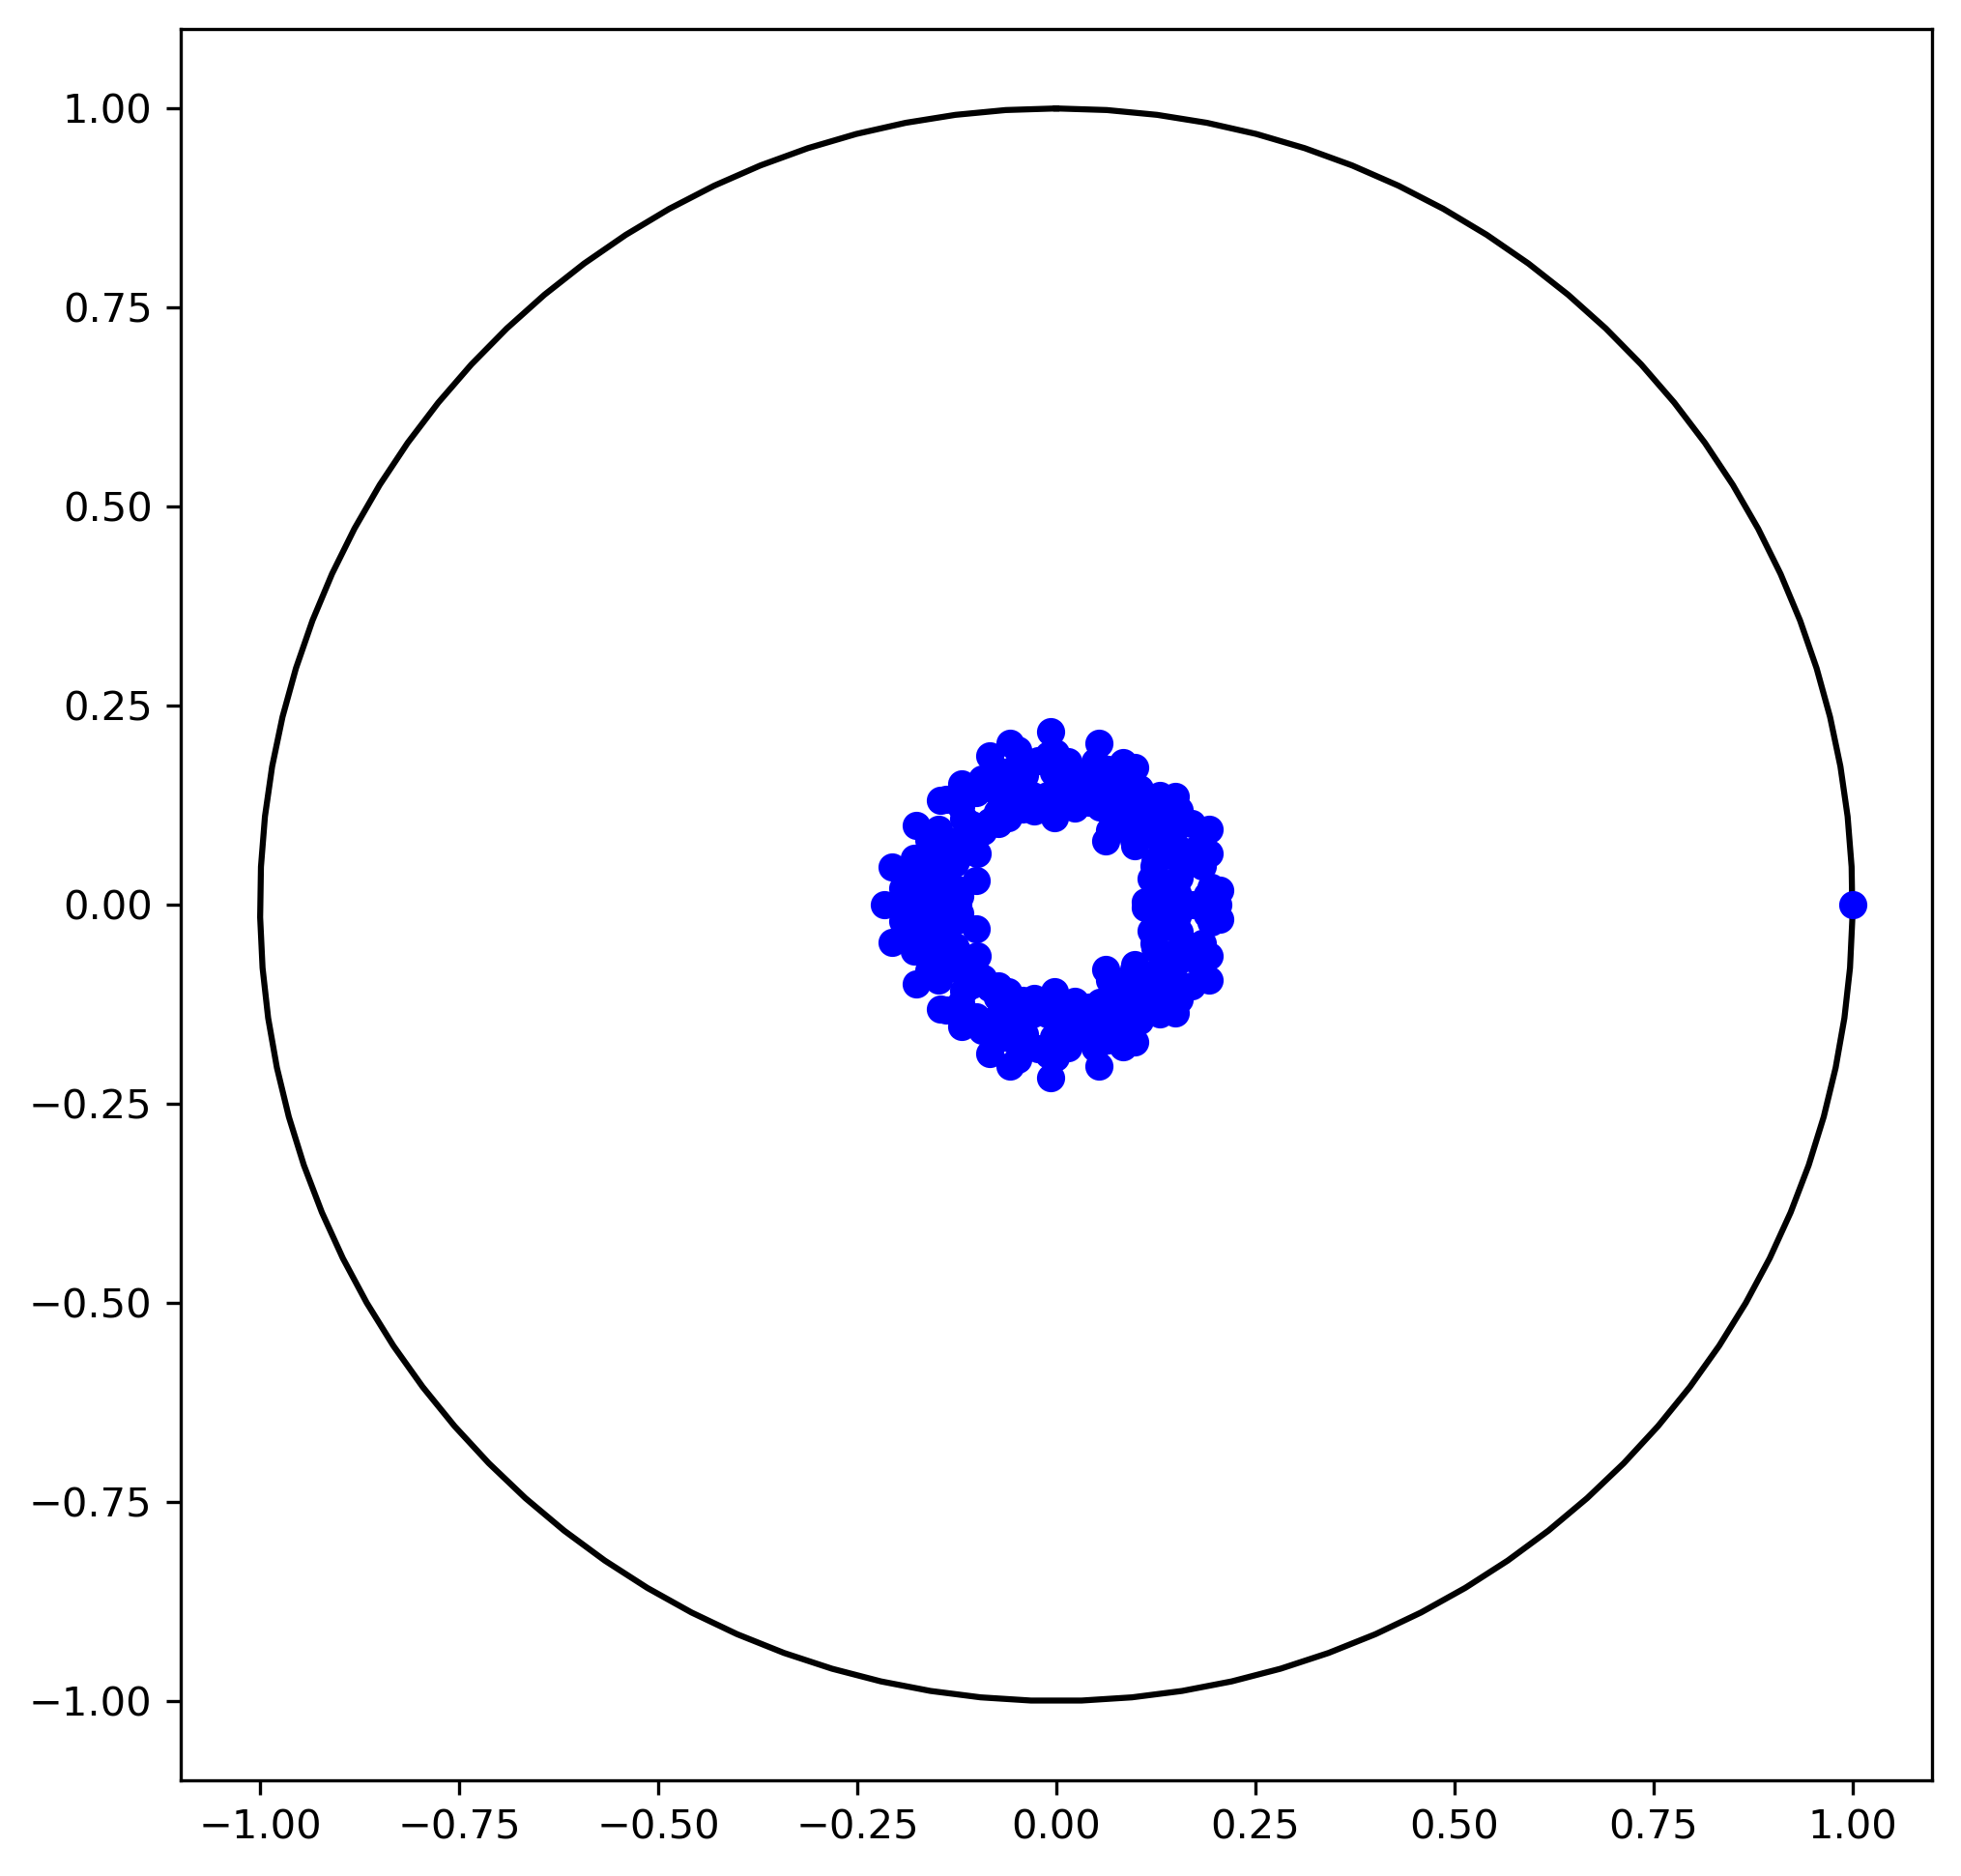

In [67]:
channel3 = model3.channel
spectrum3 = channel_spectrum(channel3, use_coords=True)

t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

fig = plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")
plt.plot(spectrum3[:,0], spectrum3[:,1], "bo")

### Seven Layers

In [68]:
inputs_map, targets_map, inputs_spam, targets_spam =  pickle.load(open(f"../../data/{'belem_4qubits_7layers0'}", "rb"))
    
d = targets_map.shape[1]
n = int(np.log2(d))

np.random.seed(43)
random.seed(43)
tf.random.set_seed(43)

spam = SPAM(init = InitialState(d, c=0.9),
            povm = POVM(d, c=0.9),
            optimizer = tf.optimizers.Adam(learning_rate=0.01),
            )

#spam.pretrain(num_iter = 1000, verbose=True)

spam.train(inputs = inputs_spam,
           targets = targets_spam,
           num_iter = 1000,
           verbose=True,
          )

  0%|          | 0/1000 [00:00<?, ?it/s]

0 0.033004687291900946
1 0.032909804078377236
2 0.03281039444906743
3 0.03270961085762105
4 0.03260872565074038
5 0.032508392713287176
6 0.032408960296581454
7 0.0323106218441987
8 0.03221346793698897
9 0.032117480578930546
10 0.03202255872537697
11 0.031928523168256534
12 0.03183514165830832
13 0.03174211671963434
14 0.031649155161917304
15 0.03155591215502981
16 0.0314621002446389
17 0.03136750861436559
18 0.031271862372929976
19 0.031174966041155727
20 0.031076651708350195
21 0.03097675435423703
22 0.03087515063043284
23 0.030771827030755112
24 0.03066670234742945
25 0.03055971551049174
26 0.030450810932346178
27 0.030339915875813687
28 0.030227042819776426
29 0.030112075531005904
30 0.029995085352522897
31 0.02987597024523574
32 0.029754708638706943
33 0.029631319998980016
34 0.029505627089399442
35 0.02937777797769644
36 0.029247788554679164
37 0.02911564543525368
38 0.02898132313881853
39 0.028844672428497878
40 0.028705471336688857
41 0.028564024029096698
42 0.028420227520821323

334 0.002743600392366457
335 0.0027390012504619845
336 0.0027342778175149167
337 0.0027296443016277595
338 0.0027251546259962007
339 0.0027207920307188984
340 0.0027165230594127583
341 0.0027122765539392742
342 0.0027080545797169412
343 0.00270378985588506
344 0.00269954441467256
345 0.0026953056309784174
346 0.002691114140869724
347 0.0026869802934818715
348 0.002682983457375853
349 0.0026791337158438974
350 0.0026753535564550276
351 0.002671621502546855
352 0.0026679053448609566
353 0.0026638065658522374
354 0.002659733911159743
355 0.002655807726020757
356 0.0026513439790037422
357 0.0026472361492905503
358 0.0026435137691240528
359 0.0026400623552258733
360 0.0026366988284549854
361 0.0026333614323134497
362 0.00262990055182444
363 0.002626423097000296
364 0.002622897201524849
365 0.002619182791824091
366 0.0026154276402406917
367 0.002611839272894927
368 0.0026084111765752945
369 0.0026051992106354404
370 0.002601933472446394
371 0.002599032461633851
372 0.002596196169861036
373 0

655 0.0021635682889501583
656 0.0021633231338077513
657 0.0021627232464657225
658 0.002162027482796895
659 0.002161367431152153
660 0.0021607985650501493
661 0.0021601865395037075
662 0.002159523314928896
663 0.0021587517617866194
664 0.002157788506007502
665 0.002156926483568452
666 0.0021564241200208775
667 0.002156246059876874
668 0.0021553954435891217
669 0.00215485907982442
670 0.0021545868672344253
671 0.0021544547867839506
672 0.0021543389612758957
673 0.002154203710342703
674 0.0021540671196326033
675 0.0021540022098164996
676 0.0021537980445631003
677 0.002152562579739089
678 0.002151549523188304
679 0.00215059766932771
680 0.002149840028633456
681 0.0021493828176049803
682 0.002149230778435598
683 0.0021492650256028293
684 0.002148845097447361
685 0.0021484543901731813
686 0.002148211298551434
687 0.0021478365265962147
688 0.002147416115688949
689 0.0021469792888457995
690 0.0021467253561432316
691 0.0021464517587628934
692 0.0021461441054923167
693 0.0021452357843276143
694 

976 0.002033290308663935
977 0.002033583488235544
978 0.002033623831496056
979 0.0020334807017440516
980 0.0020332637063679507
981 0.002033132216415755
982 0.0020332265231637688
983 0.002033520401889597
984 0.002033820931364416
985 0.002033111602380015
986 0.0020327518414265952
987 0.00203299154615364
988 0.0020337370393015805
989 0.0020337132974456613
990 0.0020320356890484712
991 0.0020302035296264173
992 0.0020281892604934286
993 0.0020268173153132644
994 0.002025955602606492
995 0.002025444990238812
996 0.0020252609009530605
997 0.002025486356862566
998 0.0020260183354841852
999 0.002026599489409847
0.002026599489409847


In [69]:
model4 = ModelQuantumMap(channel = KrausMap(d=d, 
                                           rank=256,
                                           spam = spam,
                                           ),
                               loss_function = ProbabilityMSE(),
                               optimizer = tf.optimizers.Adam(learning_rate=0.01),
                               logger = Logger(loss_function = ProbabilityMSE(), verbose=True),
                               )

model4.train(inputs = inputs_map,
            targets = targets_map,
            num_iter = 2000,
            N=500,
            )

  0%|          | 0/2000 [00:00<?, ?it/s]

0.05220220184623637 None
0.025154760060810875 None
0.01919065630248622 None
0.017580277910773646 None
0.016835675588094415 None
0.016366975190184613 None
0.016050284189894386 None
0.015807515376232664 None
0.015624699479255495 None
0.015483981995506331 None
0.01537293331287777 None
0.01527445125250327 None
0.015201361725886445 None
0.015137254383711178 None
0.015083666467991396 None
0.015045602491263303 None
0.015006742314838381 None
0.014971840192064175 None
0.014943749299115502 None
0.014925103698986959 None
0.014907039088925949 None


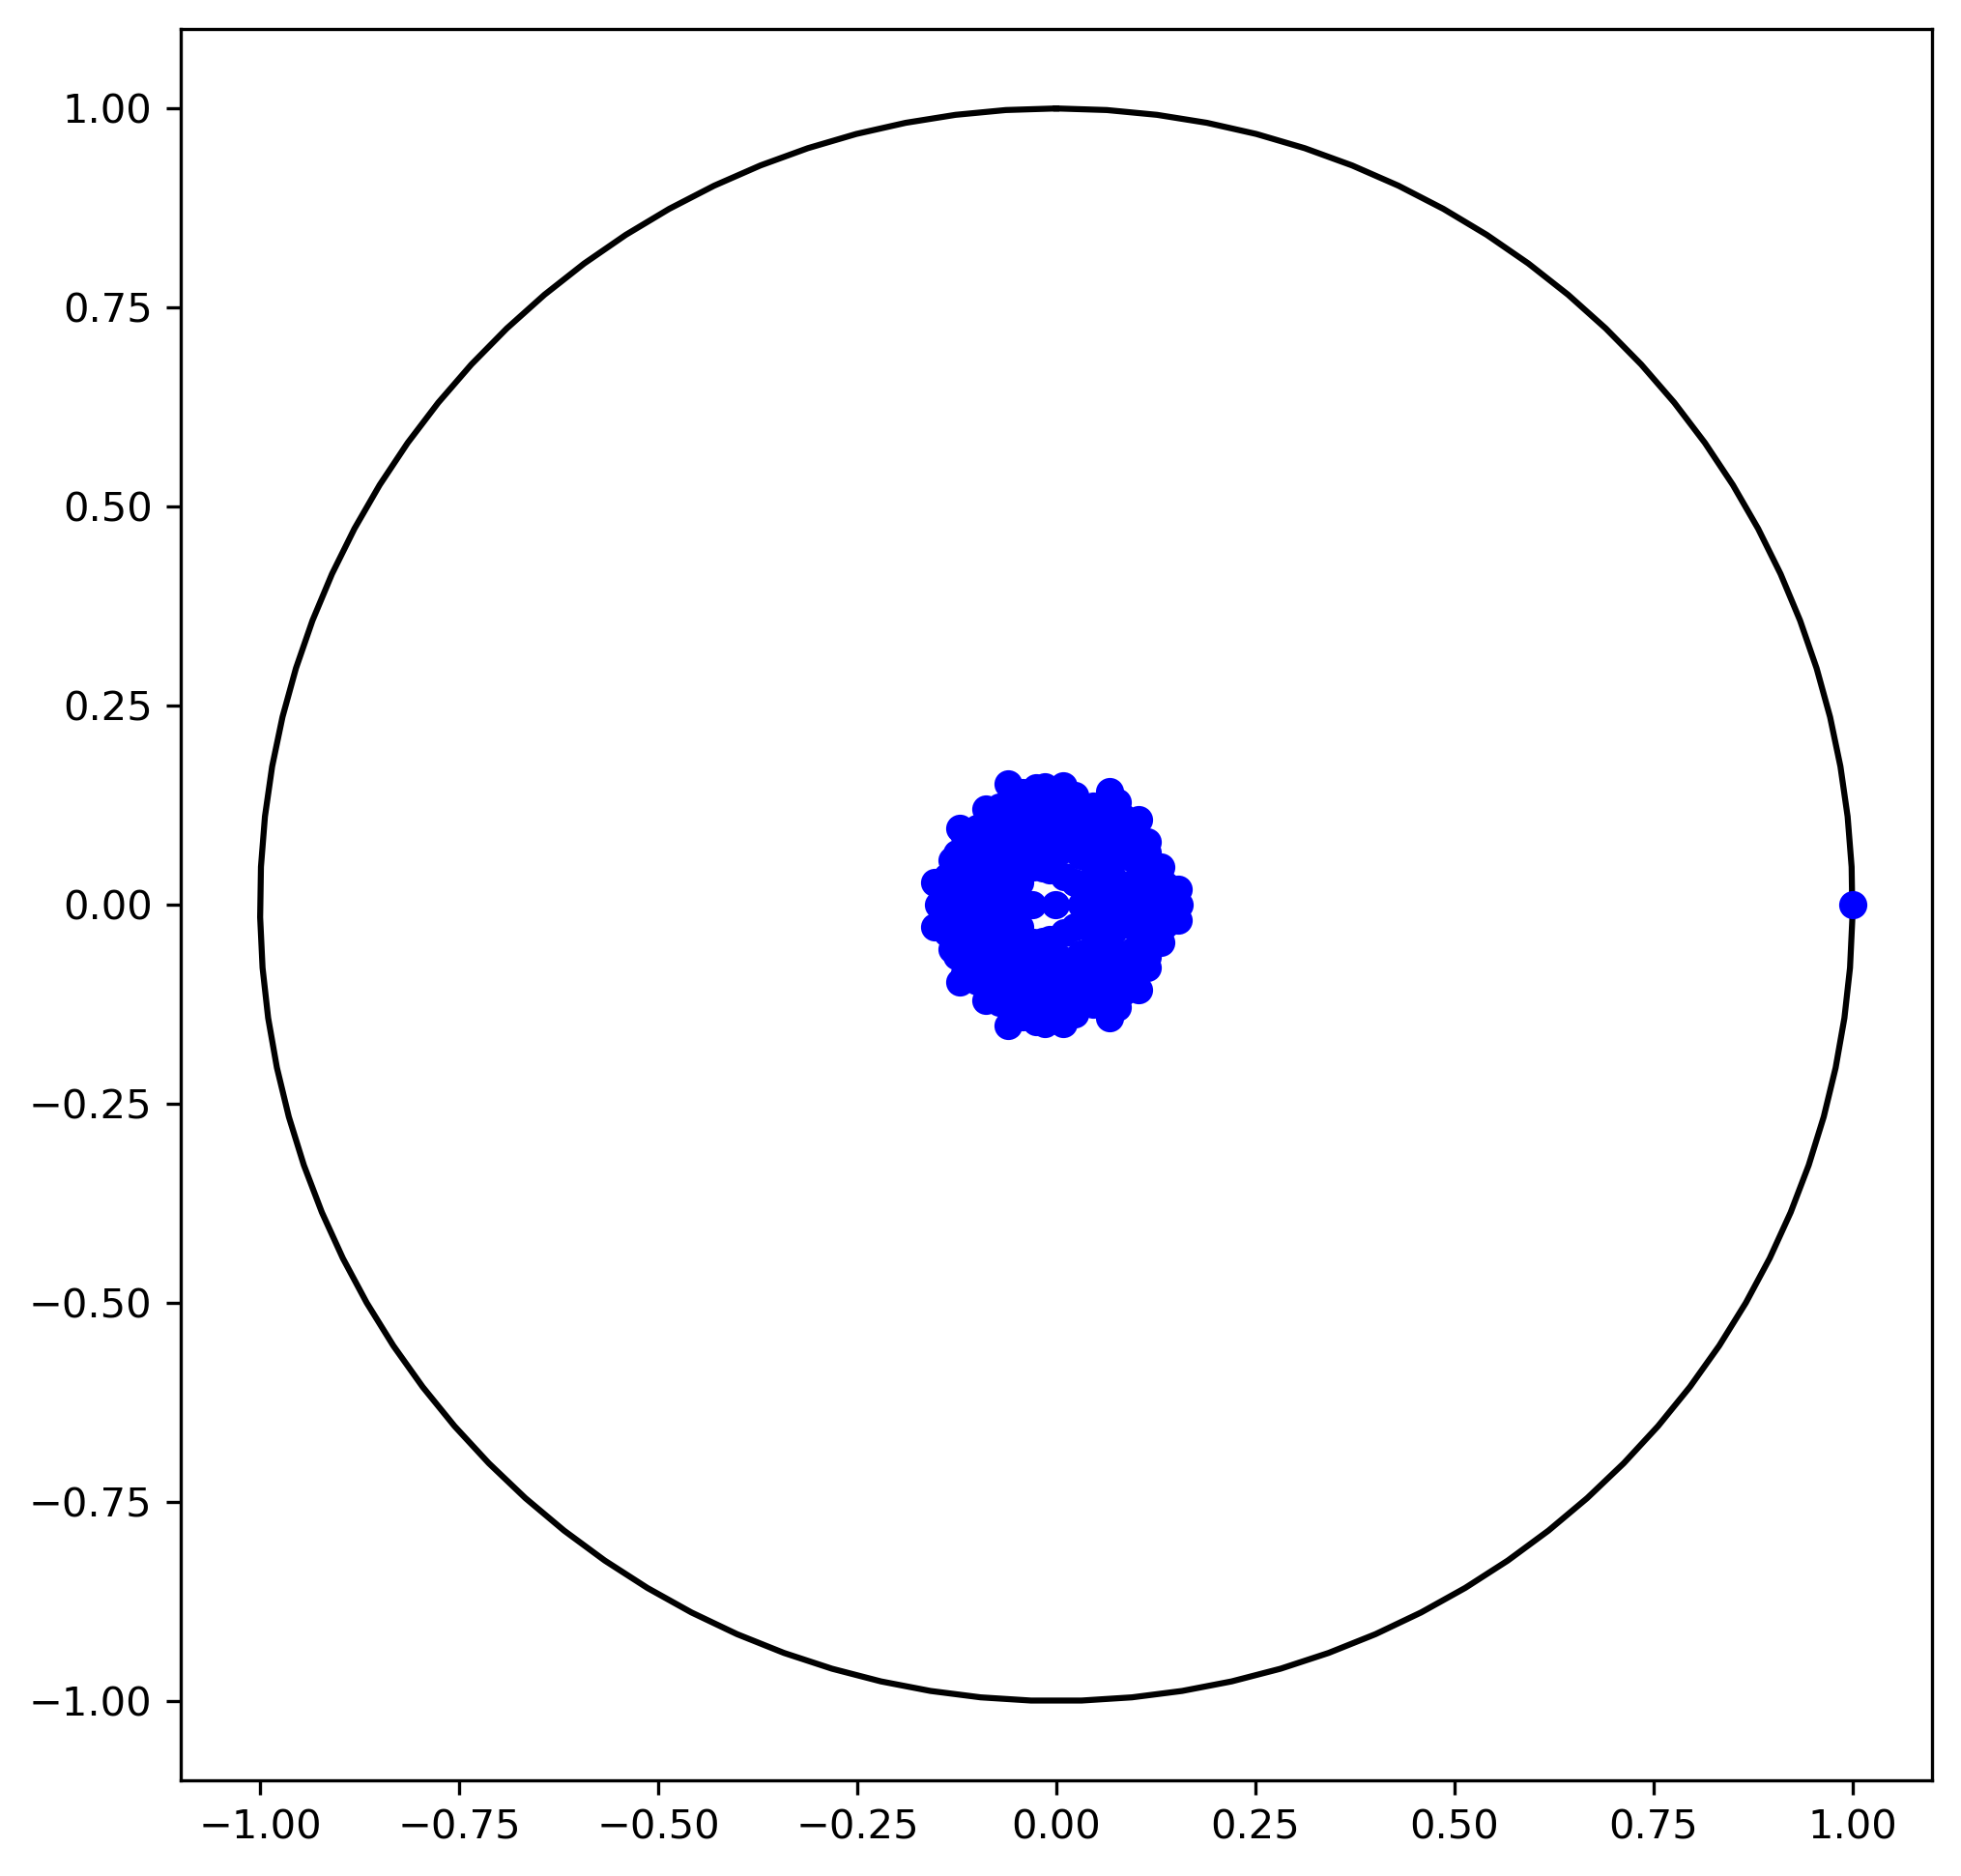

In [70]:
channel4 = model4.channel
spectrum4 = channel_spectrum(channel4, use_coords=True)

t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

fig = plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")
plt.plot(spectrum4[:,0], spectrum4[:,1], "bo")